# Question 5 (20 Marks)

Now add an attention network to your basis sequence to sequence model and train the model again. For the sake of simplicity you can use a single layered encoder and a single layered decoder (if you want you can use multiple layers also). Please answer the following questions:

(a) Did you tune the hyperparameters again? If yes please paste appropriate plots below

(b) Evaluate your best model on the test set and report the accuracy. Also upload all the predictions on the test set in a folder **predictions_attention** on your github project.

(c) Does the attention based model perform better than the vanilla model? If so, can you check some of the errors that this model corrected and note down your inferences (i.e., outputs which were predicted incorrectly by your best seq2seq model are predicted correctly by this model)

(d) In a 3 x 3 grid paste the attention heatmaps for 10 inputs from your test data (read up on what are attention heatmaps).

In [5]:
# Import necessary libraries
import wandb  # for logging visualizations and metrics
import torch
import torch.nn as nn
import torch.optim as optim
import random
from torch.nn.utils.rnn import pad_sequence

# Define the Attention mechanism used in the decoder
class Attention(nn.Module):
    def __init__(self, enc_hidden_dim, dec_hidden_dim):
        super().__init__()
        # Linear layer to compute attention energy
        self.attn = nn.Linear(enc_hidden_dim + dec_hidden_dim, dec_hidden_dim)
        # Linear layer to produce scalar attention scores
        self.v = nn.Linear(dec_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs, mask=None):
        # Repeat the decoder hidden state across the time dimension
        hidden = hidden.unsqueeze(1).repeat(1, encoder_outputs.size(1), 1)
        # Concatenate decoder hidden state and encoder outputs, then apply non-linearity
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        # Apply linear layer and squeeze to get attention scores
        attention = self.v(energy).squeeze(2)
        # Mask attention scores if padding mask is provided
        if mask is not None:
            attention = attention.masked_fill(mask == 0, -1e10)
        # Return normalized attention weights
        return torch.softmax(attention, dim=1)

# Define the Encoder module
class Encoder(nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim, cell_type='LSTM', dropout=0.2):
        super().__init__()
        # Embedding layer with padding_idx=0
        self.embedding = nn.Embedding(input_dim, embed_dim, padding_idx=0)
        # Select the RNN variant (RNN, LSTM, GRU)
        rnn_cls = {'RNN': nn.RNN, 'LSTM': nn.LSTM, 'GRU': nn.GRU}[cell_type]
        # Define the RNN layer
        self.rnn = rnn_cls(embed_dim, hidden_dim, 1, dropout=dropout, batch_first=True)
        self.cell_type = cell_type

    def forward(self, src):
        # Embed the input sequence
        embedded = self.embedding(src)
        # Pass embeddings through the RNN
        outputs, hidden = self.rnn(embedded)
        # Return all outputs and final hidden state
        return outputs, hidden

# Define the Attention-based Decoder module
class AttnDecoder(nn.Module):
    def __init__(self, output_dim, embed_dim, hidden_dim, enc_hidden_dim, attention, cell_type='LSTM', dropout=0.2):
        super().__init__()
        # Embedding layer for decoder input
        self.embedding = nn.Embedding(output_dim, embed_dim, padding_idx=0)
        self.attention = attention
        # Select the RNN variant
        rnn_cls = {'RNN': nn.RNN, 'LSTM': nn.LSTM, 'GRU': nn.GRU}[cell_type]
        # RNN takes concatenated [embedded, context] as input
        self.rnn = rnn_cls(embed_dim + enc_hidden_dim, hidden_dim, 1, dropout=dropout, batch_first=True)
        # Final output layer to map RNN output to vocabulary
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.cell_type = cell_type

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(1)  # Make input shape [batch_size, 1]
        embedded = self.embedding(input)  # Embed the input token

        # Select the hidden state to use for attention
        if self.cell_type == 'LSTM':
            dec_hidden = hidden[0][-1]  # Take last layer of hidden state (h_n)
        else:
            dec_hidden = hidden[-1]

        # Calculate attention weights
        attn_weights = self.attention(dec_hidden, encoder_outputs)
        # Compute context vector as weighted sum of encoder outputs
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        # Concatenate context and embedded input
        rnn_input = torch.cat((embedded, context), dim=2)
        # Pass through RNN
        output, hidden = self.rnn(rnn_input, hidden)
        # Generate output token probabilities
        output = self.fc_out(output.squeeze(1))
        return output, hidden, attn_weights

# Define the Seq2Seq model that combines Encoder and Attention-based Decoder
class Seq2Seq(nn.Module):
    def __init__(self, input_dim, output_dim, embed_dim, hidden_dim, cell_type='LSTM', dropout=0.2):
        super().__init__()
        # Instantiate encoder
        self.encoder = Encoder(input_dim, embed_dim, hidden_dim, cell_type, dropout)
        # Instantiate attention mechanism
        self.attention = Attention(hidden_dim, hidden_dim)
        # Instantiate decoder
        self.decoder = AttnDecoder(output_dim, embed_dim, hidden_dim, hidden_dim, self.attention, cell_type, dropout)
        self.cell_type = cell_type

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size, trg_len = trg.size()
        # Initialize output and attention tensor
        outputs = torch.zeros(batch_size, trg_len, self.decoder.fc_out.out_features, device=src.device)
        attentions = torch.zeros(batch_size, trg_len, src.size(1), device=src.device)

        # Encode source sequence
        encoder_outputs, hidden = self.encoder(src)

        input = trg[:, 0]  # Start with <sos> token
        for t in range(1, trg_len):
            # Decode next token
            output, hidden, attn_weights = self.decoder(input, hidden, encoder_outputs)
            outputs[:, t] = output
            attentions[:, t] = attn_weights
            # Apply teacher forcing
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[:, t] if teacher_force else top1

        return outputs, attentions


########## Helper Function for Logging Attention Heatmaps

import matplotlib.pyplot as plt
from matplotlib import font_manager

def log_attention_heatmaps_with_hindi(model, src_vocab, tgt_vocab, device, test_data, num_examples=9, font_path="/kaggle/input/nato-sans-devnagari/static/NotoSansDevanagari-Regular.ttf"):
    model.eval()  # Set model to evaluation mode
    examples = random.sample(test_data, num_examples)  # Randomly sample examples

    # Load Hindi font for Devanagari script rendering
    hindi_font = font_manager.FontProperties(fname=font_path)

    # Set up subplot grid for displaying attention maps
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()

    for idx, (src_text, tgt_text) in enumerate(examples):
        # Encode source and target texts to ID sequences
        src_ids = encode_sequence(src_text, src_vocab[0]) + [src_vocab[0]['<eos>']]
        trg_ids = [tgt_vocab[0]['<sos>']] + encode_sequence(tgt_text, tgt_vocab[0]) + [tgt_vocab[0]['<eos>']]

        # Convert sequences to tensors
        src_tensor = torch.tensor(src_ids, device=device).unsqueeze(0)
        trg_tensor = torch.tensor(trg_ids, device=device).unsqueeze(0)

        # Run forward pass without teacher forcing
        outputs, attentions = model(src_tensor, trg_tensor, teacher_forcing_ratio=0)

        # Extract attention weights for each decoder step
        attn = attentions[0, 1:len(trg_tensor[0])-1].detach().cpu().numpy()

        ax = axes[idx]
        # Plot attention heatmap
        im = ax.imshow(attn, aspect='auto', cmap='viridis')

        # Convert token IDs to strings
        src_tokens = [src_vocab[1][i] for i in src_ids]
        trg_tokens = [tgt_vocab[1][i] for i in trg_ids[1:-1]]

        # Set axis ticks with Hindi font labels
        ax.set_xticks(range(len(src_tokens)))
        ax.set_xticklabels(src_tokens, fontsize=12, rotation=90, fontproperties=hindi_font)

        ax.set_yticks(range(len(trg_tokens)))
        ax.set_yticklabels(trg_tokens, fontsize=12, fontproperties=hindi_font)

        ax.set_title(f"Input: {src_text}\nTarget: {tgt_text}", fontsize=14, fontproperties=hindi_font)

    plt.tight_layout()
    # Log attention heatmaps to wandb
    wandb.log({"Attention Heatmaps Hindi": wandb.Image(fig)})
    plt.show()
    plt.close()


In [3]:
import pandas as pd

# Log in to Weights & Biases for experiment tracking
wandb.login(key='acdc26d2fc17a56e83ea3ae6c10e496128dee648')

# ---------- Utility Functions ----------

# Build vocabulary from character-level sequences
def build_vocab(sequences):
    chars = set(ch for seq in sequences for ch in seq)  # Collect all unique characters
    stoi = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}  # Special tokens
    for ch in sorted(chars):
        stoi[ch] = len(stoi)  # Assign index to each character
    itos = {i: ch for ch, i in stoi.items()}  # Inverse mapping
    return stoi, itos

# Convert a sequence of characters to a list of token ids using stoi mapping
def encode_sequence(seq, stoi):
    return [stoi.get(c, stoi['<unk>']) for c in seq]  # Unknown characters get '<unk>' index

# Prepare input-output batches from sequence pairs
def prepare_batch(pairs, inp_stoi, out_stoi, device):
    # Encode and append <eos> to source; add <sos> and <eos> to target
    src_seq = [torch.tensor(encode_sequence(src, inp_stoi) + [inp_stoi['<eos>']]) for src, _ in pairs]
    trg_seq = [torch.tensor([out_stoi['<sos>']] + encode_sequence(trg, out_stoi) + [out_stoi['<eos>']]) for _, trg in pairs]
    # Pad sequences in batch
    src_batch = pad_sequence(src_seq, batch_first=True, padding_value=inp_stoi['<pad>'])
    trg_batch = pad_sequence(trg_seq, batch_first=True, padding_value=out_stoi['<pad>'])
    return src_batch.to(device), trg_batch.to(device)

# Read parallel dataset file (each line has <target>\t<input>)
def read_dataset(path):
    with open(path, encoding='utf-8') as f:
        lines = f.read().strip().split('\n')
        return [(l.split('\t')[1], l.split('\t')[0]) for l in lines if '\t' in l]

# Compute word-level accuracy by comparing full predicted vs. target sequences
def calculate_word_accuracy(preds, targets, ignore_index=0):
    preds = preds.argmax(dim=-1)  # Get token predictions by choosing max probability
    mask = targets != ignore_index  # Mask out padded tokens

    # Apply mask and compare predictions to targets
    preds_masked = preds * mask
    targets_masked = targets * mask

    # Check whether each entire sequence matches
    sequence_correct = (preds_masked == targets_masked).all(dim=1)

    # Compute percentage of correctly predicted full sequences
    word_accuracy = sequence_correct.float().mean().item() * 100
    return word_accuracy

# Alternative version: directly use predicted and target token ID tensors
def calculate_word_accuracy_from_ids(preds_ids, targets_ids, ignore_index=0):
    mask = targets_ids != ignore_index  # Ignore padded tokens
    print(mask)  # Debug print

    preds_masked = preds_ids * mask
    targets_masked = targets_ids * mask

    sequence_correct = (preds_masked == targets_masked).all(dim=1)
    word_accuracy = sequence_correct.float().mean().item() * 100
    return word_accuracy

# Evaluate model on a dataset and compute average loss and accuracy
def evaluate(model, data, src_vocab, tgt_vocab, device, criterion, batch_size):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    total_acc = 0
    with torch.no_grad():  # Disable gradient computation
        for i in range(0, len(data), batch_size):
            batch = data[i:i + batch_size]
            src, trg = prepare_batch(batch, src_vocab, tgt_vocab, device)
            output, _ = model(src, trg)  # Forward pass
            # Ignore first token (<sos>) during loss calculation
            loss = criterion(output[:, 1:].reshape(-1, output.shape[-1]), trg[:, 1:].reshape(-1))
            acc = calculate_word_accuracy(output[:, 1:], trg[:, 1:])
            total_loss += loss.item()
            total_acc += acc
    return total_loss / len(data), total_acc / (len(data) // batch_size)

# Predict on test examples and log predictions and attention using wandb
def predict_and_log_test_examples_with_attention(model, test_path, src_vocab, tgt_vocab, device, num_examples=50, output_csv_path="predictions_attention.csv"):
    model.eval()
    itos = tgt_vocab[1]  # Index-to-character for target vocabulary
    stoi = src_vocab[0]  # Character-to-index for source vocabulary

    test_data = read_dataset(test_path)
    examples = random.sample(test_data, num_examples)  # Sample test examples
    predictions_log = []

    preds_list = []
    trgs_list = []
    csv_records = []  # Records to save to CSV

    for src_text, tgt_text in examples:
        # Encode source and target sequences
        src_tensor = torch.tensor(encode_sequence(src_text, stoi) + [stoi['<eos>']], device=device).unsqueeze(0)
        trg_tensor = torch.tensor([tgt_vocab[0]['<sos>']] + encode_sequence(tgt_text, tgt_vocab[0]) + [tgt_vocab[0]['<eos>']], device=device).unsqueeze(0)

        # Run encoder
        encoder_outputs, hidden = model.encoder(src_tensor)

        # Decoder starts with <sos> token
        input = torch.tensor([tgt_vocab[0]['<sos>']], device=device)
        decoder_hidden = hidden

        decoded_tokens = []
        all_attn_weights = []  # For attention visualization

        for _ in range(30):  # Max decoding steps
            output, decoder_hidden, attn_weights = model.decoder(input, decoder_hidden, encoder_outputs)
            top1 = output.argmax(1)  # Select top prediction
            if top1.item() == tgt_vocab[0]['<eos>']:
                break  # Stop decoding at <eos>
            decoded_tokens.append(top1.item())
            all_attn_weights.append(attn_weights.detach().cpu().numpy())  # Store attention weights
            input = top1  # Feed next input

        prediction = decoded_tokens
        pred_str = ''.join([itos[idx] for idx in prediction])  # Convert prediction to string

        # Save example to CSV
        csv_records.append({
            "Input": src_text,
            "Target": tgt_text,
            "Prediction": pred_str
        })

        # Print and log prediction using wandb
        print(f"Input: {src_text} | Target: {tgt_text} | Prediction: {pred_str}")
        predictions_log.append(wandb.Html(f"<b>Input:</b> {src_text} &nbsp; <b>Target:</b> {tgt_text} &nbsp; <b>Pred:</b> {pred_str}"))

        # Prepare for accuracy computation
        tgt_encoded = [tgt_vocab[0].get(ch, tgt_vocab[0]['<unk>']) for ch in tgt_text] + [tgt_vocab[0]['<eos>']]
        preds_list.append(torch.tensor(prediction, device=device))
        trgs_list.append(torch.tensor(tgt_encoded, device=device))

    # Pad sequences to same length for accuracy computation
    max_len = max(max([p.size(0) for p in preds_list]), max([t.size(0) for t in trgs_list]))
    preds_padded = pad_sequence([torch.cat([p, torch.full((max_len - p.size(0),), 0, device=device)]) if p.size(0) < max_len else p for p in preds_list], batch_first=True)
    trgs_padded = pad_sequence([torch.cat([t, torch.full((max_len - t.size(0),), 0, device=device)]) if t.size(0) < max_len else t for t in trgs_list], batch_first=True)

    # Calculate word accuracy on test examples
    test_word_acc = calculate_word_accuracy_from_ids(preds_padded, trgs_padded)
    print(f"Test Word Accuracy on {num_examples} examples: {test_word_acc:.2f}%")

    # Log predictions and accuracy to wandb
    wandb.log({
        "Test Predictions": wandb.Html("<br>".join([str(p) for p in predictions_log])),
        "Test Word Accuracy": test_word_acc
    })

    # Save predictions to CSV file
    df = pd.DataFrame(csv_records)
    df.to_csv(output_csv_path, index=False)
    print(f"Predictions saved to {output_csv_path}")
    return test_word_acc


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: viinod9 (viinod9-iitm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
# ---------- Train Function ----------
def train():
    # Initialize a Weights & Biases (wandb) run with configuration settings
    wandb.init(config={
        "embed_dim": 128,                   # Embedding dimension for source/target tokens
        "hidden_dim": 256,                  # Hidden layer size for RNN cell
        "cell_type": "LSTM",                # Type of RNN cell to use (LSTM/GRU/RNN)
        "dropout": 0.2,                     # Dropout rate for regularization
        "epochs": 10,                       # Number of training epochs
        "batch_size": 64,                   # Mini-batch size
        "learning_rate": 0.001,             # Learning rate for optimizer
        "optimizer": "adam",                # Optimizer to use ('adam' or 'nadam')
        "teacher_forcing_ratio": 0.5,       # Probability of using teacher forcing during training
    })

    # Get configuration from wandb
    config = wandb.config

    # Set device to GPU if available, else CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load training and validation datasets (Dakshina Hindi transliteration)
    train_data = read_dataset("/kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv")
    dev_data = read_dataset("/kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv")

    # Build source and target vocabularies from training data
    src_vocab, tgt_vocab = build_vocab([src for src, _ in train_data]), build_vocab([tgt for _, tgt in train_data])

    # Initialize Seq2Seq model with attention (1-layer encoder-decoder as per assignment requirement)
    model = Seq2Seq(len(src_vocab[0]), len(tgt_vocab[0]), config.embed_dim, config.hidden_dim,
                    config.cell_type, config.dropout).to(device)

    # Initialize optimizer based on configuration
    if config.optimizer == "adam":
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    elif config.optimizer == "nadam":
        optimizer = optim.NAdam(model.parameters(), lr=config.learning_rate)
    else:
        raise ValueError("Unsupported optimizer")  # Raise error if unsupported optimizer is given

    # Define loss function (ignoring padding index = 0)
    criterion = nn.CrossEntropyLoss(ignore_index=0)

    # Loop over all epochs
    for epoch in range(config.epochs):
        model.train()                       # Set model to training mode
        total_loss = 0                      # Track cumulative training loss
        total_acc = 0                       # Track cumulative word-level accuracy
        random.shuffle(train_data)         # Shuffle training data before each epoch

        # Process data in mini-batches
        for i in range(0, len(train_data), config.batch_size):
            batch = train_data[i:i + config.batch_size]

            # Prepare input and target tensors for the batch
            src, trg = prepare_batch(batch, src_vocab[0], tgt_vocab[0], device)

            optimizer.zero_grad()          # Reset gradients
            output, _ = model(src, trg, teacher_forcing_ratio=config.teacher_forcing_ratio)

            # Compute loss (excluding the <sos> token in output and target)
            loss = criterion(output[:, 1:].reshape(-1, output.shape[-1]), trg[:, 1:].reshape(-1))

            # Calculate word-level accuracy for the batch
            acc = calculate_word_accuracy(output[:, 1:], trg[:, 1:])

            loss.backward()                # Backpropagate loss
            optimizer.step()               # Update model parameters

            total_loss += loss.item()      # Accumulate loss
            total_acc += acc               # Accumulate accuracy

        # Calculate average loss and accuracy over all training batches
        avg_train_loss = total_loss / len(train_data)
        avg_train_acc = total_acc / (len(train_data) // config.batch_size)

        # Evaluate model on validation data
        val_loss, val_acc = evaluate(model, dev_data, src_vocab[0], tgt_vocab[0], device, criterion, config.batch_size)

        # Log metrics to wandb
        wandb.log({
            "Train Loss": avg_train_loss,
            "Train Accuracy": avg_train_acc,
            "Validation Loss": val_loss,
            "Validation Accuracy": val_acc,
            "Epoch": epoch + 1,
            "Learning Rate": config.learning_rate,
            "Teacher Forcing Ratio": config.teacher_forcing_ratio,
        })

        # Print epoch-wise performance
        print(f"Epoch {epoch + 1}/{config.epochs} | Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Finish the wandb run
    wandb.finish()


# ---------- Sweep Setup ----------
# Define a sweep configuration for hyperparameter tuning using Bayesian optimization
sweep_config = {
    'method': 'bayes',  # Bayesian optimization for efficient hyperparameter search
    'metric': {'name': 'Validation Accuracy', 'goal': 'maximize'},  # Target metric to optimize

    # Search space for hyperparameters
    'parameters': {
        'embed_dim': {'values': [32, 64, 256]},             # Embedding dimension options
        'hidden_dim': {'values': [64, 128]},                # Hidden layer sizes
        'enc_layers': {'values': [1,2,3]},                  # Number of encoder layers
        'dec_layers': {'values': [1,2,3]},                  # Number of decoder layers
        'cell_type': {'values': ['LSTM','GRU','RNN']},      # RNN variant to use
        'dropout': {'values': [0.2, 0.3]},                  # Dropout rate
        'batch_size': {'values': [32,64]},                  # Batch sizes
        'epochs': {'values': [5,10,15]},                    # Epoch counts
        'bidirectional': {'values': [False]},               # (Fixed) Use unidirectional encoder
        'learning_rate': {'values': [0.001, 0.002, 0.0001]},# Learning rates
        'optimizer': {'values': ['adam', 'nadam']},         # Optimizer choices
        'teacher_forcing_ratio': {'values': [0.2, 0.5, 0.7]}, # Teacher forcing ratios
        'beam_width': {'values': [1, 3, 5]}                 # Beam search width for decoding
    }
}

# Create sweep on wandb and start agent to run 80 trials with different hyperparameter combinations
# The 'train' function is used as the training routine
sweep_id = wandb.sweep(sweep_config, project="with_attention_sweep")
wandb.agent(sweep_id, function=train, count=80)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: viinod9 (viinod9-iitm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Create sweep with ID: genvy1yp
Sweep URL: https://wandb.ai/viinod9-iitm/with_attention_sweep/sweeps/genvy1yp


wandb: Agent Starting Run: yuqwysfk with config:
wandb: 	batch_size: 64
wandb: 	beam_width: 5
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 3
wandb: 	dropout: 0.2
wandb: 	embed_dim: 64
wandb: 	enc_layers: 3
wandb: 	epochs: 15
wandb: 	hidden_dim: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	teacher_forcing_ratio: 0.2
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1/15 | Train Loss: 0.0526, Train Acc: 0.00% | Val Loss: 0.0494, Val Acc: 0.00%
Epoch 2/15 | Train Loss: 0.0468, Train Acc: 0.00% | Val Loss: 0.0463, Val Acc: 0.00%
Epoch 3/15 | Train Loss: 0.0443, Train Acc: 0.01% | Val Loss: 0.0438, Val Acc: 0.00%
Epoch 4/15 | Train Loss: 0.0423, Train Acc: 0.05% | Val Loss: 0.0417, Val Acc: 0.00%
Epoch 5/15 | Train Loss: 0.0404, Train Acc: 0.10% | Val Loss: 0.0396, Val Acc: 0.09%
Epoch 6/15 | Train Loss: 0.0385, Train Acc: 0.20% | Val Loss: 0.0375, Val Acc: 0.16%
Epoch 7/15 | Train Loss: 0.0364, Train Acc: 0.40% | Val Loss: 0.0350, Val Acc: 0.46%
Epoch 8/15 | Train Loss: 0.0340, Train Acc: 0.75% | Val Loss: 0.0324, Val Acc: 0.99%
Epoch 9/15 | Train Loss: 0.0309, Train Acc: 1.58% | Val Loss: 0.0290, Val Acc: 2.05%
Epoch 10/15 | Train Loss: 0.0276, Train Acc: 3.33% | Val Loss: 0.0256, Val Acc: 4.66%
Epoch 11/15 | Train Loss: 0.0246, Train Acc: 6.17% | Val Loss: 0.0230, Val Acc: 7.61%
Epoch 12/15 | Train Loss: 0.0225, Train Acc: 8.84% | Val Loss: 

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▁▁▁▁▁▁▁▂▃▄▆▇▇█
Train Loss,█▇▆▆▅▅▅▄▃▃▂▂▁▁▁
Validation Accuracy,▁▁▁▁▁▁▁▁▂▃▅▆▇██
Validation Loss,█▇▇▆▆▅▅▄▃▃▂▂▁▁▁
Epoch,15
Learning Rate,0.0001
Teacher Forcing Ratio,0.2
Train Accuracy,13.57708


wandb: Agent Starting Run: jqeccrxy with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 3
wandb: 	bidirectional: False
wandb: 	cell_type: RNN
wandb: 	dec_layers: 2
wandb: 	dropout: 0.3
wandb: 	embed_dim: 32
wandb: 	enc_layers: 3
wandb: 	epochs: 5
wandb: 	hidden_dim: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.5


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 1/5 | Train Loss: 0.0557, Train Acc: 7.50% | Val Loss: 0.0368, Val Acc: 15.77%
Epoch 2/5 | Train Loss: 0.0335, Train Acc: 18.73% | Val Loss: 0.0319, Val Acc: 21.17%
Epoch 3/5 | Train Loss: 0.0295, Train Acc: 23.14% | Val Loss: 0.0297, Val Acc: 22.89%
Epoch 4/5 | Train Loss: 0.0274, Train Acc: 25.40% | Val Loss: 0.0284, Val Acc: 24.86%
Epoch 5/5 | Train Loss: 0.0258, Train Acc: 27.36% | Val Loss: 0.0281, Val Acc: 26.87%


Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁
Train Accuracy,▁▅▇▇█
Train Loss,█▃▂▁▁
Validation Accuracy,▁▄▅▇█
Validation Loss,█▄▂▁▁
Epoch,5
Learning Rate,0.001
Teacher Forcing Ratio,0.5
Train Accuracy,27.35865


wandb: Agent Starting Run: 1286whmr with config:
wandb: 	batch_size: 64
wandb: 	beam_width: 5
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 2
wandb: 	dropout: 0.3
wandb: 	embed_dim: 256
wandb: 	enc_layers: 2
wandb: 	epochs: 10
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/10 | Train Loss: 0.0476, Train Acc: 0.03% | Val Loss: 0.0419, Val Acc: 0.00%
Epoch 2/10 | Train Loss: 0.0362, Train Acc: 0.50% | Val Loss: 0.0351, Val Acc: 0.69%
Epoch 3/10 | Train Loss: 0.0289, Train Acc: 2.52% | Val Loss: 0.0279, Val Acc: 4.41%
Epoch 4/10 | Train Loss: 0.0218, Train Acc: 8.05% | Val Loss: 0.0215, Val Acc: 11.80%
Epoch 5/10 | Train Loss: 0.0173, Train Acc: 14.77% | Val Loss: 0.0186, Val Acc: 17.11%
Epoch 6/10 | Train Loss: 0.0150, Train Acc: 18.82% | Val Loss: 0.0170, Val Acc: 19.39%
Epoch 7/10 | Train Loss: 0.0136, Train Acc: 21.55% | Val Loss: 0.0158, Val Acc: 21.50%
Epoch 8/10 | Train Loss: 0.0127, Train Acc: 24.04% | Val Loss: 0.0150, Val Acc: 23.61%
Epoch 9/10 | Train Loss: 0.0119, Train Acc: 26.17% | Val Loss: 0.0149, Val Acc: 24.90%
Epoch 10/10 | Train Loss: 0.0112, Train Acc: 28.23% | Val Loss: 0.0146, Val Acc: 27.45%


Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▁▂▃▅▆▆▇▇█
Train Loss,█▆▄▃▂▂▁▁▁▁
Validation Accuracy,▁▁▂▄▅▆▆▇▇█
Validation Loss,█▆▄▃▂▂▁▁▁▁
Epoch,10
Learning Rate,0.0001
Teacher Forcing Ratio,0.7
Train Accuracy,28.22999


wandb: Agent Starting Run: fclcj2sr with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 3
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 2
wandb: 	dropout: 0.2
wandb: 	embed_dim: 256
wandb: 	enc_layers: 3
wandb: 	epochs: 5
wandb: 	hidden_dim: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.5


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1/5 | Train Loss: 0.0599, Train Acc: 5.65% | Val Loss: 0.0367, Val Acc: 14.85%
Epoch 2/5 | Train Loss: 0.0320, Train Acc: 18.97% | Val Loss: 0.0303, Val Acc: 21.91%
Epoch 3/5 | Train Loss: 0.0275, Train Acc: 24.59% | Val Loss: 0.0284, Val Acc: 25.10%
Epoch 4/5 | Train Loss: 0.0250, Train Acc: 28.30% | Val Loss: 0.0268, Val Acc: 27.63%
Epoch 5/5 | Train Loss: 0.0236, Train Acc: 30.58% | Val Loss: 0.0273, Val Acc: 28.44%


Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁
Train Accuracy,▁▅▆▇█
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▆██
Validation Loss,█▃▂▁▁
Epoch,5
Learning Rate,0.001
Teacher Forcing Ratio,0.5
Train Accuracy,30.57944


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gpkpfnfp with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 3
wandb: 	bidirectional: False
wandb: 	cell_type: GRU
wandb: 	dec_layers: 3
wandb: 	dropout: 0.3
wandb: 	embed_dim: 64
wandb: 	enc_layers: 3
wandb: 	epochs: 10
wandb: 	hidden_dim: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/10 | Train Loss: 0.0518, Train Acc: 9.83% | Val Loss: 0.0341, Val Acc: 20.60%
Epoch 2/10 | Train Loss: 0.0260, Train Acc: 24.27% | Val Loss: 0.0285, Val Acc: 26.04%
Epoch 3/10 | Train Loss: 0.0222, Train Acc: 29.43% | Val Loss: 0.0266, Val Acc: 29.36%
Epoch 4/10 | Train Loss: 0.0204, Train Acc: 32.41% | Val Loss: 0.0263, Val Acc: 30.58%
Epoch 5/10 | Train Loss: 0.0191, Train Acc: 34.55% | Val Loss: 0.0256, Val Acc: 31.72%
Epoch 6/10 | Train Loss: 0.0183, Train Acc: 36.05% | Val Loss: 0.0262, Val Acc: 31.75%
Epoch 7/10 | Train Loss: 0.0174, Train Acc: 37.56% | Val Loss: 0.0235, Val Acc: 33.84%
Epoch 8/10 | Train Loss: 0.0170, Train Acc: 38.71% | Val Loss: 0.0238, Val Acc: 34.18%
Epoch 9/10 | Train Loss: 0.0163, Train Acc: 40.14% | Val Loss: 0.0231, Val Acc: 34.08%
Epoch 10/10 | Train Loss: 0.0157, Train Acc: 40.89% | Val Loss: 0.0231, Val Acc: 35.38%


Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▆▇▇▇███
Train Loss,█▃▂▂▂▂▁▁▁▁
Validation Accuracy,▁▄▅▆▆▆▇▇▇█
Validation Loss,█▄▃▃▃▃▁▁▁▁
Epoch,10
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,40.88975


wandb: Agent Starting Run: syqmowrp with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 3
wandb: 	bidirectional: False
wandb: 	cell_type: RNN
wandb: 	dec_layers: 3
wandb: 	dropout: 0.3
wandb: 	embed_dim: 256
wandb: 	enc_layers: 3
wandb: 	epochs: 10
wandb: 	hidden_dim: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/10 | Train Loss: 0.0575, Train Acc: 6.08% | Val Loss: 0.0385, Val Acc: 16.33%
Epoch 2/10 | Train Loss: 0.0293, Train Acc: 20.18% | Val Loss: 0.0311, Val Acc: 23.02%
Epoch 3/10 | Train Loss: 0.0259, Train Acc: 24.52% | Val Loss: 0.0304, Val Acc: 25.20%
Epoch 4/10 | Train Loss: 0.0238, Train Acc: 26.92% | Val Loss: 0.0321, Val Acc: 23.31%
Epoch 5/10 | Train Loss: 0.0257, Train Acc: 24.94% | Val Loss: 0.0308, Val Acc: 24.75%
Epoch 6/10 | Train Loss: 0.0235, Train Acc: 27.49% | Val Loss: 0.0295, Val Acc: 27.08%
Epoch 7/10 | Train Loss: 0.0220, Train Acc: 29.51% | Val Loss: 0.0300, Val Acc: 27.68%
Epoch 8/10 | Train Loss: 0.0215, Train Acc: 30.09% | Val Loss: 0.0281, Val Acc: 28.81%
Epoch 9/10 | Train Loss: 0.0211, Train Acc: 30.87% | Val Loss: 0.0279, Val Acc: 27.84%
Epoch 10/10 | Train Loss: 0.0209, Train Acc: 31.17% | Val Loss: 0.0273, Val Acc: 29.90%


Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▅▆▇▆▇████
Train Loss,█▃▂▂▂▁▁▁▁▁
Validation Accuracy,▁▄▆▅▅▇▇▇▇█
Validation Loss,█▃▃▄▃▂▃▁▁▁
Epoch,10
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,31.17231


wandb: Agent Starting Run: ngi2w73i with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 3
wandb: 	bidirectional: False
wandb: 	cell_type: GRU
wandb: 	dec_layers: 3
wandb: 	dropout: 0.3
wandb: 	embed_dim: 256
wandb: 	enc_layers: 3
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0358, Train Acc: 18.20% | Val Loss: 0.0279, Val Acc: 27.32%
Epoch 2/15 | Train Loss: 0.0203, Train Acc: 32.36% | Val Loss: 0.0250, Val Acc: 31.38%
Epoch 3/15 | Train Loss: 0.0175, Train Acc: 36.95% | Val Loss: 0.0245, Val Acc: 32.26%
Epoch 4/15 | Train Loss: 0.0164, Train Acc: 39.64% | Val Loss: 0.0228, Val Acc: 34.53%
Epoch 5/15 | Train Loss: 0.0153, Train Acc: 42.04% | Val Loss: 0.0236, Val Acc: 34.97%
Epoch 6/15 | Train Loss: 0.0146, Train Acc: 44.18% | Val Loss: 0.0224, Val Acc: 36.79%
Epoch 7/15 | Train Loss: 0.0140, Train Acc: 45.46% | Val Loss: 0.0224, Val Acc: 35.81%
Epoch 8/15 | Train Loss: 0.0135, Train Acc: 46.97% | Val Loss: 0.0224, Val Acc: 35.69%
Epoch 9/15 | Train Loss: 0.0130, Train Acc: 48.20% | Val Loss: 0.0223, Val Acc: 36.02%
Epoch 10/15 | Train Loss: 0.0124, Train Acc: 49.69% | Val Loss: 0.0231, Val Acc: 36.00%
Epoch 11/15 | Train Loss: 0.0123, Train Acc: 50.44% | Val Loss: 0.0222, Val Acc: 36.27%
Epoch 12/15 | Train Loss: 0.0118, Train A

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▅▆▆▆▇▇▇▇▇███
Train Loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
Validation Accuracy,▁▄▄▆▆▇▇▇▇▇▇█▇██
Validation Loss,█▄▄▂▃▁▁▁▁▂▁▁▁▂▁
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,54.10557


wandb: Agent Starting Run: zf3uvfj6 with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: GRU
wandb: 	dec_layers: 3
wandb: 	dropout: 0.3
wandb: 	embed_dim: 256
wandb: 	enc_layers: 3
wandb: 	epochs: 10
wandb: 	hidden_dim: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/10 | Train Loss: 0.0488, Train Acc: 10.40% | Val Loss: 0.0340, Val Acc: 20.40%
Epoch 2/10 | Train Loss: 0.0258, Train Acc: 24.11% | Val Loss: 0.0292, Val Acc: 24.72%
Epoch 3/10 | Train Loss: 0.0228, Train Acc: 28.20% | Val Loss: 0.0270, Val Acc: 27.91%
Epoch 4/10 | Train Loss: 0.0211, Train Acc: 30.85% | Val Loss: 0.0258, Val Acc: 30.12%
Epoch 5/10 | Train Loss: 0.0200, Train Acc: 32.66% | Val Loss: 0.0267, Val Acc: 29.18%
Epoch 6/10 | Train Loss: 0.0193, Train Acc: 34.20% | Val Loss: 0.0259, Val Acc: 31.14%
Epoch 7/10 | Train Loss: 0.0187, Train Acc: 35.18% | Val Loss: 0.0252, Val Acc: 30.71%
Epoch 8/10 | Train Loss: 0.0180, Train Acc: 36.53% | Val Loss: 0.0251, Val Acc: 32.62%
Epoch 9/10 | Train Loss: 0.0176, Train Acc: 37.22% | Val Loss: 0.0242, Val Acc: 34.10%
Epoch 10/10 | Train Loss: 0.0172, Train Acc: 37.88% | Val Loss: 0.0243, Val Acc: 32.79%


Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▆▆▇▇▇███
Train Loss,█▃▂▂▂▁▁▁▁▁
Validation Accuracy,▁▃▅▆▅▆▆▇█▇
Validation Loss,█▅▃▂▃▂▂▂▁▁
Epoch,10
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,37.88318


wandb: Agent Starting Run: 8iqgabb4 with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 5
wandb: 	bidirectional: False
wandb: 	cell_type: GRU
wandb: 	dec_layers: 3
wandb: 	dropout: 0.3
wandb: 	embed_dim: 256
wandb: 	enc_layers: 3
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0358, Train Acc: 18.27% | Val Loss: 0.0289, Val Acc: 28.42%
Epoch 2/15 | Train Loss: 0.0203, Train Acc: 32.34% | Val Loss: 0.0249, Val Acc: 31.82%
Epoch 3/15 | Train Loss: 0.0177, Train Acc: 36.85% | Val Loss: 0.0242, Val Acc: 32.71%
Epoch 4/15 | Train Loss: 0.0164, Train Acc: 39.42% | Val Loss: 0.0234, Val Acc: 33.33%
Epoch 5/15 | Train Loss: 0.0154, Train Acc: 42.03% | Val Loss: 0.0224, Val Acc: 35.61%
Epoch 6/15 | Train Loss: 0.0146, Train Acc: 43.92% | Val Loss: 0.0225, Val Acc: 34.90%
Epoch 7/15 | Train Loss: 0.0141, Train Acc: 45.28% | Val Loss: 0.0235, Val Acc: 35.68%
Epoch 8/15 | Train Loss: 0.0134, Train Acc: 46.80% | Val Loss: 0.0223, Val Acc: 35.78%
Epoch 9/15 | Train Loss: 0.0130, Train Acc: 48.00% | Val Loss: 0.0232, Val Acc: 35.95%
Epoch 10/15 | Train Loss: 0.0126, Train Acc: 49.48% | Val Loss: 0.0230, Val Acc: 37.41%
Epoch 11/15 | Train Loss: 0.0122, Train Acc: 50.42% | Val Loss: 0.0228, Val Acc: 36.25%
Epoch 12/15 | Train Loss: 0.0120, Train A

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▅▆▆▆▇▇▇▇▇███
Train Loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
Validation Accuracy,▁▄▄▅▇▆▇▇▇█▇▇▇█▇
Validation Loss,█▄▃▂▁▁▂▁▂▂▂▂▂▁▂
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,53.62132


wandb: Agent Starting Run: poi2ti2f with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: RNN
wandb: 	dec_layers: 3
wandb: 	dropout: 0.3
wandb: 	embed_dim: 64
wandb: 	enc_layers: 2
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0399, Train Acc: 15.23% | Val Loss: 0.0335, Val Acc: 20.17%
Epoch 2/15 | Train Loss: 0.0234, Train Acc: 27.68% | Val Loss: 0.0272, Val Acc: 27.47%
Epoch 3/15 | Train Loss: 0.0204, Train Acc: 31.93% | Val Loss: 0.0243, Val Acc: 31.23%
Epoch 4/15 | Train Loss: 0.0188, Train Acc: 34.62% | Val Loss: 0.0250, Val Acc: 33.78%
Epoch 5/15 | Train Loss: 0.0178, Train Acc: 36.81% | Val Loss: 0.0232, Val Acc: 32.84%
Epoch 6/15 | Train Loss: 0.0168, Train Acc: 38.53% | Val Loss: 0.0261, Val Acc: 32.35%
Epoch 7/15 | Train Loss: 0.0163, Train Acc: 39.96% | Val Loss: 0.0243, Val Acc: 34.51%
Epoch 8/15 | Train Loss: 0.0157, Train Acc: 41.47% | Val Loss: 0.0233, Val Acc: 34.56%
Epoch 9/15 | Train Loss: 0.0152, Train Acc: 41.99% | Val Loss: 0.0233, Val Acc: 34.88%
Epoch 10/15 | Train Loss: 0.0149, Train Acc: 43.18% | Val Loss: 0.0243, Val Acc: 35.42%
Epoch 11/15 | Train Loss: 0.0144, Train Acc: 44.24% | Val Loss: 0.0228, Val Acc: 33.75%
Epoch 12/15 | Train Loss: 0.0140, Train A

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▅▆▆▆▇▇▇▇████
Train Loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁
Validation Accuracy,▁▄▆▇▇▆▇▇██▇████
Validation Loss,█▄▂▂▁▃▂▁▁▂▁▂▁▁▂
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,46.90743


wandb: Agent Starting Run: ahlk3h5x with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 3
wandb: 	bidirectional: False
wandb: 	cell_type: GRU
wandb: 	dec_layers: 2
wandb: 	dropout: 0.3
wandb: 	embed_dim: 64
wandb: 	enc_layers: 2
wandb: 	epochs: 15
wandb: 	hidden_dim: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0507, Train Acc: 10.51% | Val Loss: 0.0334, Val Acc: 21.12%
Epoch 2/15 | Train Loss: 0.0254, Train Acc: 24.56% | Val Loss: 0.0309, Val Acc: 24.97%
Epoch 3/15 | Train Loss: 0.0219, Train Acc: 29.67% | Val Loss: 0.0279, Val Acc: 26.18%
Epoch 4/15 | Train Loss: 0.0201, Train Acc: 32.41% | Val Loss: 0.0259, Val Acc: 30.86%
Epoch 5/15 | Train Loss: 0.0192, Train Acc: 34.48% | Val Loss: 0.0250, Val Acc: 32.29%
Epoch 6/15 | Train Loss: 0.0182, Train Acc: 36.10% | Val Loss: 0.0247, Val Acc: 33.46%
Epoch 7/15 | Train Loss: 0.0175, Train Acc: 37.61% | Val Loss: 0.0249, Val Acc: 34.26%
Epoch 8/15 | Train Loss: 0.0167, Train Acc: 38.76% | Val Loss: 0.0244, Val Acc: 33.26%
Epoch 9/15 | Train Loss: 0.0164, Train Acc: 40.14% | Val Loss: 0.0228, Val Acc: 34.05%
Epoch 10/15 | Train Loss: 0.0158, Train Acc: 41.14% | Val Loss: 0.0224, Val Acc: 35.90%
Epoch 11/15 | Train Loss: 0.0156, Train Acc: 41.81% | Val Loss: 0.0239, Val Acc: 35.68%
Epoch 12/15 | Train Loss: 0.0152, Train A

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▆▆▆▇▇▇▇▇████
Train Loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁
Validation Accuracy,▁▃▃▅▆▆▇▆▇▇▇██▇█
Validation Loss,█▇▅▃▃▃▃▃▂▁▂▂▂▂▁
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,44.47638


wandb: Agent Starting Run: 5frwctv9 with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 3
wandb: 	dropout: 0.3
wandb: 	embed_dim: 64
wandb: 	enc_layers: 1
wandb: 	epochs: 10
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.002
wandb: 	optimizer: nadam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/10 | Train Loss: 0.0370, Train Acc: 18.21% | Val Loss: 0.0271, Val Acc: 29.00%
Epoch 2/10 | Train Loss: 0.0193, Train Acc: 34.17% | Val Loss: 0.0247, Val Acc: 34.39%
Epoch 3/10 | Train Loss: 0.0166, Train Acc: 39.27% | Val Loss: 0.0225, Val Acc: 35.87%
Epoch 4/10 | Train Loss: 0.0151, Train Acc: 42.45% | Val Loss: 0.0223, Val Acc: 36.28%
Epoch 5/10 | Train Loss: 0.0141, Train Acc: 45.24% | Val Loss: 0.0210, Val Acc: 36.56%
Epoch 6/10 | Train Loss: 0.0131, Train Acc: 47.52% | Val Loss: 0.0209, Val Acc: 38.19%
Epoch 7/10 | Train Loss: 0.0125, Train Acc: 49.29% | Val Loss: 0.0218, Val Acc: 37.97%
Epoch 8/10 | Train Loss: 0.0119, Train Acc: 51.12% | Val Loss: 0.0230, Val Acc: 36.76%
Epoch 9/10 | Train Loss: 0.0114, Train Acc: 52.47% | Val Loss: 0.0219, Val Acc: 37.81%
Epoch 10/10 | Train Loss: 0.0109, Train Acc: 54.24% | Val Loss: 0.0235, Val Acc: 38.27%


Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▆▆▇▇▇██
Train Loss,█▃▃▂▂▂▁▁▁▁
Validation Accuracy,▁▅▆▇▇██▇██
Validation Loss,█▅▃▃▁▁▂▃▂▄
Epoch,10
Learning Rate,0.002
Teacher Forcing Ratio,0.7
Train Accuracy,54.23757


wandb: Agent Starting Run: 52dy5azj with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 3
wandb: 	dropout: 0.3
wandb: 	embed_dim: 32
wandb: 	enc_layers: 1
wandb: 	epochs: 15
wandb: 	hidden_dim: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0714, Train Acc: 2.33% | Val Loss: 0.0427, Val Acc: 11.86%
Epoch 2/15 | Train Loss: 0.0321, Train Acc: 16.92% | Val Loss: 0.0327, Val Acc: 19.57%
Epoch 3/15 | Train Loss: 0.0257, Train Acc: 24.10% | Val Loss: 0.0294, Val Acc: 26.49%
Epoch 4/15 | Train Loss: 0.0230, Train Acc: 28.61% | Val Loss: 0.0270, Val Acc: 29.64%
Epoch 5/15 | Train Loss: 0.0212, Train Acc: 31.32% | Val Loss: 0.0263, Val Acc: 31.59%
Epoch 6/15 | Train Loss: 0.0198, Train Acc: 33.43% | Val Loss: 0.0264, Val Acc: 32.70%
Epoch 7/15 | Train Loss: 0.0188, Train Acc: 35.12% | Val Loss: 0.0244, Val Acc: 32.58%
Epoch 8/15 | Train Loss: 0.0179, Train Acc: 36.99% | Val Loss: 0.0238, Val Acc: 34.48%
Epoch 9/15 | Train Loss: 0.0173, Train Acc: 38.08% | Val Loss: 0.0239, Val Acc: 35.06%
Epoch 10/15 | Train Loss: 0.0168, Train Acc: 39.26% | Val Loss: 0.0236, Val Acc: 35.39%
Epoch 11/15 | Train Loss: 0.0163, Train Acc: 40.38% | Val Loss: 0.0245, Val Acc: 34.20%
Epoch 12/15 | Train Loss: 0.0157, Train Ac

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▃▅▅▆▆▇▇▇▇▇████
Train Loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁
Validation Accuracy,▁▃▅▆▇▇▇▇██▇████
Validation Loss,█▅▃▃▂▂▂▂▂▂▂▁▂▁▁
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,43.69569


wandb: Agent Starting Run: nnwzj5wh with config:
wandb: 	batch_size: 64
wandb: 	beam_width: 3
wandb: 	bidirectional: False
wandb: 	cell_type: GRU
wandb: 	dec_layers: 3
wandb: 	dropout: 0.3
wandb: 	embed_dim: 64
wandb: 	enc_layers: 3
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0237, Train Acc: 12.61% | Val Loss: 0.0157, Val Acc: 23.07%
Epoch 2/15 | Train Loss: 0.0116, Train Acc: 27.73% | Val Loss: 0.0134, Val Acc: 30.46%
Epoch 3/15 | Train Loss: 0.0097, Train Acc: 34.14% | Val Loss: 0.0121, Val Acc: 32.67%
Epoch 4/15 | Train Loss: 0.0087, Train Acc: 38.00% | Val Loss: 0.0116, Val Acc: 33.85%
Epoch 5/15 | Train Loss: 0.0079, Train Acc: 40.92% | Val Loss: 0.0115, Val Acc: 35.23%
Epoch 6/15 | Train Loss: 0.0074, Train Acc: 42.93% | Val Loss: 0.0110, Val Acc: 36.88%
Epoch 7/15 | Train Loss: 0.0070, Train Acc: 45.18% | Val Loss: 0.0106, Val Acc: 38.37%
Epoch 8/15 | Train Loss: 0.0066, Train Acc: 46.94% | Val Loss: 0.0107, Val Acc: 37.94%
Epoch 9/15 | Train Loss: 0.0063, Train Acc: 49.14% | Val Loss: 0.0116, Val Acc: 37.52%
Epoch 10/15 | Train Loss: 0.0060, Train Acc: 50.63% | Val Loss: 0.0103, Val Acc: 38.51%
Epoch 11/15 | Train Loss: 0.0058, Train Acc: 52.01% | Val Loss: 0.0102, Val Acc: 39.84%
Epoch 12/15 | Train Loss: 0.0055, Train A

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▃▄▅▅▆▆▆▇▇▇▇███
Train Loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁
Validation Accuracy,▁▄▅▅▆▇▇▇▇▇█████
Validation Loss,█▅▃▃▃▂▂▂▃▁▁▂▂▂▂
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,57.26655


wandb: Agent Starting Run: ks5bee9f with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	embed_dim: 32
wandb: 	enc_layers: 1
wandb: 	epochs: 10
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/10 | Train Loss: 0.0636, Train Acc: 3.05% | Val Loss: 0.0435, Val Acc: 10.29%
Epoch 2/10 | Train Loss: 0.0290, Train Acc: 20.41% | Val Loss: 0.0307, Val Acc: 23.28%
Epoch 3/10 | Train Loss: 0.0212, Train Acc: 31.23% | Val Loss: 0.0258, Val Acc: 29.96%
Epoch 4/10 | Train Loss: 0.0179, Train Acc: 37.31% | Val Loss: 0.0243, Val Acc: 32.32%
Epoch 5/10 | Train Loss: 0.0161, Train Acc: 41.49% | Val Loss: 0.0233, Val Acc: 35.12%
Epoch 6/10 | Train Loss: 0.0145, Train Acc: 44.99% | Val Loss: 0.0230, Val Acc: 36.10%
Epoch 7/10 | Train Loss: 0.0135, Train Acc: 48.05% | Val Loss: 0.0223, Val Acc: 36.27%
Epoch 8/10 | Train Loss: 0.0125, Train Acc: 50.62% | Val Loss: 0.0222, Val Acc: 37.90%
Epoch 9/10 | Train Loss: 0.0118, Train Acc: 52.64% | Val Loss: 0.0224, Val Acc: 36.99%
Epoch 10/10 | Train Loss: 0.0109, Train Acc: 54.95% | Val Loss: 0.0221, Val Acc: 37.07%


Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▃▅▆▆▇▇▇██
Train Loss,█▃▂▂▂▁▁▁▁▁
Validation Accuracy,▁▄▆▇▇█████
Validation Loss,█▄▂▂▁▁▁▁▁▁
Epoch,10
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,54.95188


wandb: Agent Starting Run: se2kdj8f with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 5
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	embed_dim: 32
wandb: 	enc_layers: 2
wandb: 	epochs: 15
wandb: 	hidden_dim: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0730, Train Acc: 1.70% | Val Loss: 0.0464, Val Acc: 9.58%
Epoch 2/15 | Train Loss: 0.0316, Train Acc: 17.83% | Val Loss: 0.0337, Val Acc: 21.30%
Epoch 3/15 | Train Loss: 0.0247, Train Acc: 25.18% | Val Loss: 0.0289, Val Acc: 26.10%
Epoch 4/15 | Train Loss: 0.0220, Train Acc: 29.45% | Val Loss: 0.0267, Val Acc: 29.75%
Epoch 5/15 | Train Loss: 0.0202, Train Acc: 32.77% | Val Loss: 0.0258, Val Acc: 30.77%
Epoch 6/15 | Train Loss: 0.0188, Train Acc: 34.62% | Val Loss: 0.0240, Val Acc: 32.46%
Epoch 7/15 | Train Loss: 0.0180, Train Acc: 36.12% | Val Loss: 0.0238, Val Acc: 34.44%
Epoch 8/15 | Train Loss: 0.0173, Train Acc: 37.87% | Val Loss: 0.0230, Val Acc: 34.86%
Epoch 9/15 | Train Loss: 0.0166, Train Acc: 39.27% | Val Loss: 0.0239, Val Acc: 34.81%
Epoch 10/15 | Train Loss: 0.0162, Train Acc: 40.20% | Val Loss: 0.0226, Val Acc: 35.24%
Epoch 11/15 | Train Loss: 0.0158, Train Acc: 41.37% | Val Loss: 0.0226, Val Acc: 35.73%
Epoch 12/15 | Train Loss: 0.0154, Train Acc

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▆▆▆▇▇▇▇▇████
Train Loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▄▅▆▆▇▇▇▇▇█████
Validation Loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,44.71096


wandb: Agent Starting Run: 6l9rxhsv with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 3
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 2
wandb: 	dropout: 0.3
wandb: 	embed_dim: 32
wandb: 	enc_layers: 2
wandb: 	epochs: 10
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/10 | Train Loss: 0.0522, Train Acc: 9.72% | Val Loss: 0.0330, Val Acc: 21.08%
Epoch 2/10 | Train Loss: 0.0246, Train Acc: 25.97% | Val Loss: 0.0287, Val Acc: 29.34%
Epoch 3/10 | Train Loss: 0.0202, Train Acc: 32.58% | Val Loss: 0.0251, Val Acc: 32.58%
Epoch 4/10 | Train Loss: 0.0179, Train Acc: 36.55% | Val Loss: 0.0242, Val Acc: 33.91%
Epoch 5/10 | Train Loss: 0.0164, Train Acc: 39.94% | Val Loss: 0.0229, Val Acc: 35.50%
Epoch 6/10 | Train Loss: 0.0153, Train Acc: 42.71% | Val Loss: 0.0215, Val Acc: 36.99%
Epoch 7/10 | Train Loss: 0.0142, Train Acc: 45.17% | Val Loss: 0.0221, Val Acc: 37.65%
Epoch 8/10 | Train Loss: 0.0133, Train Acc: 47.15% | Val Loss: 0.0210, Val Acc: 38.16%
Epoch 9/10 | Train Loss: 0.0125, Train Acc: 49.38% | Val Loss: 0.0211, Val Acc: 38.25%
Epoch 10/10 | Train Loss: 0.0119, Train Acc: 51.12% | Val Loss: 0.0223, Val Acc: 38.99%


Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▆▆▇▇▇██
Train Loss,█▃▂▂▂▂▁▁▁▁
Validation Accuracy,▁▄▅▆▇▇▇███
Validation Loss,█▆▃▃▂▁▂▁▁▂
Epoch,10
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,51.12162


wandb: Agent Starting Run: 71l1vnsf with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 3
wandb: 	dropout: 0.3
wandb: 	embed_dim: 64
wandb: 	enc_layers: 1
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.002
wandb: 	optimizer: nadam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0370, Train Acc: 19.00% | Val Loss: 0.0312, Val Acc: 24.36%
Epoch 2/15 | Train Loss: 0.0194, Train Acc: 33.51% | Val Loss: 0.0240, Val Acc: 34.90%
Epoch 3/15 | Train Loss: 0.0166, Train Acc: 39.13% | Val Loss: 0.0230, Val Acc: 36.35%
Epoch 4/15 | Train Loss: 0.0150, Train Acc: 43.08% | Val Loss: 0.0217, Val Acc: 36.83%
Epoch 5/15 | Train Loss: 0.0139, Train Acc: 45.78% | Val Loss: 0.0216, Val Acc: 37.75%
Epoch 6/15 | Train Loss: 0.0131, Train Acc: 47.78% | Val Loss: 0.0214, Val Acc: 37.16%
Epoch 7/15 | Train Loss: 0.0124, Train Acc: 49.88% | Val Loss: 0.0227, Val Acc: 37.40%
Epoch 8/15 | Train Loss: 0.0117, Train Acc: 52.00% | Val Loss: 0.0227, Val Acc: 38.20%
Epoch 9/15 | Train Loss: 0.0111, Train Acc: 53.46% | Val Loss: 0.0216, Val Acc: 38.69%
Epoch 10/15 | Train Loss: 0.0106, Train Acc: 55.16% | Val Loss: 0.0224, Val Acc: 37.09%
Epoch 11/15 | Train Loss: 0.0104, Train Acc: 55.85% | Val Loss: 0.0224, Val Acc: 38.90%
Epoch 12/15 | Train Loss: 0.0099, Train A

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▃▄▅▅▆▆▇▇▇▇▇███
Train Loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
Validation Accuracy,▁▆▇▇▇▇▇██▇██▇██
Validation Loss,█▃▂▁▁▁▂▂▁▂▂▂▂▁▂
Epoch,15
Learning Rate,0.002
Teacher Forcing Ratio,0.7
Train Accuracy,60.8006


wandb: Agent Starting Run: md4tfsbo with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 3
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 2
wandb: 	dropout: 0.3
wandb: 	embed_dim: 64
wandb: 	enc_layers: 3
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0462, Train Acc: 12.74% | Val Loss: 0.0298, Val Acc: 24.04%
Epoch 2/15 | Train Loss: 0.0220, Train Acc: 29.34% | Val Loss: 0.0254, Val Acc: 31.54%
Epoch 3/15 | Train Loss: 0.0184, Train Acc: 35.90% | Val Loss: 0.0243, Val Acc: 34.83%
Epoch 4/15 | Train Loss: 0.0164, Train Acc: 39.84% | Val Loss: 0.0224, Val Acc: 35.91%
Epoch 5/15 | Train Loss: 0.0151, Train Acc: 42.98% | Val Loss: 0.0227, Val Acc: 36.99%
Epoch 6/15 | Train Loss: 0.0140, Train Acc: 45.58% | Val Loss: 0.0214, Val Acc: 38.11%
Epoch 7/15 | Train Loss: 0.0130, Train Acc: 47.92% | Val Loss: 0.0221, Val Acc: 36.53%
Epoch 8/15 | Train Loss: 0.0124, Train Acc: 49.94% | Val Loss: 0.0208, Val Acc: 38.45%
Epoch 9/15 | Train Loss: 0.0116, Train Acc: 51.96% | Val Loss: 0.0212, Val Acc: 39.06%
Epoch 10/15 | Train Loss: 0.0110, Train Acc: 54.14% | Val Loss: 0.0219, Val Acc: 38.79%
Epoch 11/15 | Train Loss: 0.0104, Train Acc: 55.60% | Val Loss: 0.0214, Val Acc: 39.58%
Epoch 12/15 | Train Loss: 0.0099, Train A

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▃▄▅▅▆▆▆▇▇▇▇███
Train Loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁
Validation Accuracy,▁▄▆▆▇▇▆▇█▇███▇█
Validation Loss,█▅▄▂▂▁▂▁▁▂▁▁▂▂▂
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,61.32181


wandb: Agent Starting Run: 19p471b1 with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 3
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	embed_dim: 32
wandb: 	enc_layers: 2
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0516, Train Acc: 10.50% | Val Loss: 0.0313, Val Acc: 22.31%
Epoch 2/15 | Train Loss: 0.0234, Train Acc: 27.69% | Val Loss: 0.0263, Val Acc: 30.16%
Epoch 3/15 | Train Loss: 0.0191, Train Acc: 34.33% | Val Loss: 0.0240, Val Acc: 33.37%
Epoch 4/15 | Train Loss: 0.0171, Train Acc: 38.39% | Val Loss: 0.0231, Val Acc: 35.19%
Epoch 5/15 | Train Loss: 0.0155, Train Acc: 41.61% | Val Loss: 0.0228, Val Acc: 36.33%
Epoch 6/15 | Train Loss: 0.0144, Train Acc: 44.26% | Val Loss: 0.0222, Val Acc: 36.47%
Epoch 7/15 | Train Loss: 0.0136, Train Acc: 46.70% | Val Loss: 0.0219, Val Acc: 37.06%
Epoch 8/15 | Train Loss: 0.0128, Train Acc: 48.81% | Val Loss: 0.0215, Val Acc: 38.17%
Epoch 9/15 | Train Loss: 0.0119, Train Acc: 51.03% | Val Loss: 0.0204, Val Acc: 37.88%
Epoch 10/15 | Train Loss: 0.0114, Train Acc: 52.71% | Val Loss: 0.0220, Val Acc: 38.55%
Epoch 11/15 | Train Loss: 0.0110, Train Acc: 54.55% | Val Loss: 0.0222, Val Acc: 39.75%
Epoch 12/15 | Train Loss: 0.0103, Train A

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▃▄▅▅▆▆▆▇▇▇▇███
Train Loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁
Validation Accuracy,▁▄▅▆▇▇▇▇▇██▇███
Validation Loss,█▅▃▃▃▂▂▂▁▂▂▂▂▂▂
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,59.99351


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pvm5xqvh with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: GRU
wandb: 	dec_layers: 2
wandb: 	dropout: 0.2
wandb: 	embed_dim: 32
wandb: 	enc_layers: 2
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0419, Train Acc: 15.01% | Val Loss: 0.0302, Val Acc: 24.77%
Epoch 2/15 | Train Loss: 0.0224, Train Acc: 28.63% | Val Loss: 0.0255, Val Acc: 30.68%
Epoch 3/15 | Train Loss: 0.0191, Train Acc: 34.36% | Val Loss: 0.0238, Val Acc: 34.25%
Epoch 4/15 | Train Loss: 0.0169, Train Acc: 38.37% | Val Loss: 0.0236, Val Acc: 35.01%
Epoch 5/15 | Train Loss: 0.0156, Train Acc: 41.30% | Val Loss: 0.0217, Val Acc: 37.65%
Epoch 6/15 | Train Loss: 0.0147, Train Acc: 43.76% | Val Loss: 0.0234, Val Acc: 36.89%
Epoch 7/15 | Train Loss: 0.0137, Train Acc: 46.13% | Val Loss: 0.0223, Val Acc: 38.13%
Epoch 8/15 | Train Loss: 0.0130, Train Acc: 48.08% | Val Loss: 0.0237, Val Acc: 37.03%
Epoch 9/15 | Train Loss: 0.0125, Train Acc: 49.45% | Val Loss: 0.0220, Val Acc: 38.45%
Epoch 10/15 | Train Loss: 0.0118, Train Acc: 51.58% | Val Loss: 0.0221, Val Acc: 38.99%
Epoch 11/15 | Train Loss: 0.0113, Train Acc: 52.77% | Val Loss: 0.0216, Val Acc: 39.58%
Epoch 12/15 | Train Loss: 0.0108, Train A

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▃▄▅▅▆▆▆▇▇▇▇███
Train Loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
Validation Accuracy,▁▄▅▆▇▇▇▇▇██████
Validation Loss,█▄▃▃▂▃▂▃▂▂▂▁▂▂▂
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,58.06104


wandb: Agent Starting Run: bfsxrdzg with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 3
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 2
wandb: 	dropout: 0.3
wandb: 	embed_dim: 32
wandb: 	enc_layers: 1
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.002
wandb: 	optimizer: nadam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0402, Train Acc: 16.68% | Val Loss: 0.0288, Val Acc: 28.06%
Epoch 2/15 | Train Loss: 0.0201, Train Acc: 32.97% | Val Loss: 0.0252, Val Acc: 33.24%
Epoch 3/15 | Train Loss: 0.0169, Train Acc: 38.44% | Val Loss: 0.0236, Val Acc: 34.23%
Epoch 4/15 | Train Loss: 0.0153, Train Acc: 42.56% | Val Loss: 0.0221, Val Acc: 36.11%
Epoch 5/15 | Train Loss: 0.0141, Train Acc: 45.28% | Val Loss: 0.0214, Val Acc: 37.42%
Epoch 6/15 | Train Loss: 0.0131, Train Acc: 47.96% | Val Loss: 0.0232, Val Acc: 36.31%
Epoch 7/15 | Train Loss: 0.0124, Train Acc: 50.01% | Val Loss: 0.0213, Val Acc: 37.62%
Epoch 8/15 | Train Loss: 0.0117, Train Acc: 52.19% | Val Loss: 0.0209, Val Acc: 40.11%
Epoch 9/15 | Train Loss: 0.0110, Train Acc: 53.94% | Val Loss: 0.0230, Val Acc: 39.04%
Epoch 10/15 | Train Loss: 0.0106, Train Acc: 55.01% | Val Loss: 0.0222, Val Acc: 38.83%
Epoch 11/15 | Train Loss: 0.0102, Train Acc: 56.80% | Val Loss: 0.0225, Val Acc: 38.30%
Epoch 12/15 | Train Loss: 0.0097, Train A

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▄▅▅▆▆▇▇▇▇▇███
Train Loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁
Validation Accuracy,▁▄▅▆▆▆▇█▇▇▇▇▇▇▇
Validation Loss,█▅▃▂▁▃▁▁▃▂▂▃▄▄▄
Epoch,15
Learning Rate,0.002
Teacher Forcing Ratio,0.7
Train Accuracy,61.42137


wandb: Agent Starting Run: h1fppwq7 with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: GRU
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	embed_dim: 64
wandb: 	enc_layers: 3
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0392, Train Acc: 16.61% | Val Loss: 0.0292, Val Acc: 25.32%
Epoch 2/15 | Train Loss: 0.0210, Train Acc: 30.84% | Val Loss: 0.0246, Val Acc: 31.76%
Epoch 3/15 | Train Loss: 0.0180, Train Acc: 36.38% | Val Loss: 0.0230, Val Acc: 34.42%
Epoch 4/15 | Train Loss: 0.0162, Train Acc: 39.83% | Val Loss: 0.0218, Val Acc: 36.03%
Epoch 5/15 | Train Loss: 0.0149, Train Acc: 42.51% | Val Loss: 0.0222, Val Acc: 36.31%
Epoch 6/15 | Train Loss: 0.0139, Train Acc: 45.35% | Val Loss: 0.0222, Val Acc: 36.06%
Epoch 7/15 | Train Loss: 0.0132, Train Acc: 47.42% | Val Loss: 0.0211, Val Acc: 38.61%
Epoch 8/15 | Train Loss: 0.0124, Train Acc: 49.52% | Val Loss: 0.0217, Val Acc: 38.04%
Epoch 9/15 | Train Loss: 0.0119, Train Acc: 50.78% | Val Loss: 0.0220, Val Acc: 37.05%
Epoch 10/15 | Train Loss: 0.0114, Train Acc: 52.25% | Val Loss: 0.0226, Val Acc: 38.83%
Epoch 11/15 | Train Loss: 0.0108, Train Acc: 53.91% | Val Loss: 0.0222, Val Acc: 38.07%
Epoch 12/15 | Train Loss: 0.0106, Train A

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▃▄▅▅▆▆▇▇▇▇▇███
Train Loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
Validation Accuracy,▁▄▆▆▇▆█▇▇█▇█▇██
Validation Loss,█▄▃▂▂▂▁▂▂▂▂▁▂▂▂
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,58.44195


wandb: Agent Starting Run: lkqxlk58 with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 5
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	embed_dim: 32
wandb: 	enc_layers: 2
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0551, Train Acc: 8.23% | Val Loss: 0.0319, Val Acc: 21.97%
Epoch 2/15 | Train Loss: 0.0237, Train Acc: 27.36% | Val Loss: 0.0267, Val Acc: 29.69%
Epoch 3/15 | Train Loss: 0.0194, Train Acc: 34.15% | Val Loss: 0.0245, Val Acc: 32.99%
Epoch 4/15 | Train Loss: 0.0172, Train Acc: 38.22% | Val Loss: 0.0237, Val Acc: 32.45%
Epoch 5/15 | Train Loss: 0.0155, Train Acc: 41.72% | Val Loss: 0.0225, Val Acc: 37.10%
Epoch 6/15 | Train Loss: 0.0143, Train Acc: 44.68% | Val Loss: 0.0223, Val Acc: 37.84%
Epoch 7/15 | Train Loss: 0.0134, Train Acc: 46.95% | Val Loss: 0.0212, Val Acc: 38.48%
Epoch 8/15 | Train Loss: 0.0125, Train Acc: 49.09% | Val Loss: 0.0229, Val Acc: 38.00%
Epoch 9/15 | Train Loss: 0.0118, Train Acc: 51.22% | Val Loss: 0.0220, Val Acc: 39.02%
Epoch 10/15 | Train Loss: 0.0113, Train Acc: 53.16% | Val Loss: 0.0211, Val Acc: 39.12%
Epoch 11/15 | Train Loss: 0.0106, Train Acc: 55.07% | Val Loss: 0.0222, Val Acc: 40.32%
Epoch 12/15 | Train Loss: 0.0101, Train Ac

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▄▅▅▆▆▆▇▇▇▇███
Train Loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁
Validation Accuracy,▁▄▅▅▇▇▇▇▇▇██▇▇█
Validation Loss,█▅▃▃▂▂▁▂▂▁▂▂▂▂▂
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,61.13776


wandb: Agent Starting Run: ctmv7qpg with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 3
wandb: 	dropout: 0.3
wandb: 	embed_dim: 64
wandb: 	enc_layers: 2
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0475, Train Acc: 12.22% | Val Loss: 0.0309, Val Acc: 21.88%
Epoch 2/15 | Train Loss: 0.0218, Train Acc: 29.95% | Val Loss: 0.0248, Val Acc: 31.92%
Epoch 3/15 | Train Loss: 0.0183, Train Acc: 36.33% | Val Loss: 0.0227, Val Acc: 34.26%
Epoch 4/15 | Train Loss: 0.0163, Train Acc: 39.91% | Val Loss: 0.0229, Val Acc: 34.28%
Epoch 5/15 | Train Loss: 0.0149, Train Acc: 43.62% | Val Loss: 0.0235, Val Acc: 37.03%
Epoch 6/15 | Train Loss: 0.0139, Train Acc: 46.32% | Val Loss: 0.0221, Val Acc: 37.46%
Epoch 7/15 | Train Loss: 0.0129, Train Acc: 48.55% | Val Loss: 0.0209, Val Acc: 38.89%
Epoch 8/15 | Train Loss: 0.0121, Train Acc: 50.43% | Val Loss: 0.0221, Val Acc: 38.69%
Epoch 9/15 | Train Loss: 0.0115, Train Acc: 52.42% | Val Loss: 0.0212, Val Acc: 39.32%
Epoch 10/15 | Train Loss: 0.0108, Train Acc: 54.21% | Val Loss: 0.0208, Val Acc: 40.49%
Epoch 11/15 | Train Loss: 0.0103, Train Acc: 55.97% | Val Loss: 0.0225, Val Acc: 39.96%
Epoch 12/15 | Train Loss: 0.0099, Train A

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▄▅▅▆▆▆▇▇▇▇███
Train Loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁
Validation Accuracy,▁▅▆▆▇▇▇▇█████▇█
Validation Loss,█▄▂▂▃▂▁▂▁▁▂▁▁▁▂
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,61.84377


wandb: Agent Starting Run: agji4feq with config:
wandb: 	batch_size: 64
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	embed_dim: 32
wandb: 	enc_layers: 1
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0337, Train Acc: 3.75% | Val Loss: 0.0199, Val Acc: 15.18%
Epoch 2/15 | Train Loss: 0.0143, Train Acc: 20.82% | Val Loss: 0.0155, Val Acc: 23.45%
Epoch 3/15 | Train Loss: 0.0114, Train Acc: 28.93% | Val Loss: 0.0138, Val Acc: 30.76%
Epoch 4/15 | Train Loss: 0.0098, Train Acc: 33.82% | Val Loss: 0.0124, Val Acc: 33.68%
Epoch 5/15 | Train Loss: 0.0089, Train Acc: 37.45% | Val Loss: 0.0122, Val Acc: 35.53%
Epoch 6/15 | Train Loss: 0.0081, Train Acc: 40.24% | Val Loss: 0.0116, Val Acc: 34.70%
Epoch 7/15 | Train Loss: 0.0077, Train Acc: 42.85% | Val Loss: 0.0114, Val Acc: 36.96%
Epoch 8/15 | Train Loss: 0.0072, Train Acc: 44.94% | Val Loss: 0.0113, Val Acc: 37.23%
Epoch 9/15 | Train Loss: 0.0068, Train Acc: 46.98% | Val Loss: 0.0111, Val Acc: 37.42%
Epoch 10/15 | Train Loss: 0.0064, Train Acc: 48.76% | Val Loss: 0.0111, Val Acc: 37.72%
Epoch 11/15 | Train Loss: 0.0061, Train Acc: 50.40% | Val Loss: 0.0110, Val Acc: 38.73%
Epoch 12/15 | Train Loss: 0.0058, Train Ac

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▃▄▅▅▆▆▆▇▇▇▇███
Train Loss,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁
Validation Accuracy,▁▃▅▆▇▇▇▇▇▇█████
Validation Loss,█▅▄▂▂▂▂▂▁▁▁▁▂▁▁
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,56.34161


wandb: Agent Starting Run: 4p4k908q with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 5
wandb: 	bidirectional: False
wandb: 	cell_type: RNN
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	embed_dim: 32
wandb: 	enc_layers: 2
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0451, Train Acc: 12.65% | Val Loss: 0.0332, Val Acc: 21.72%
Epoch 2/15 | Train Loss: 0.0253, Train Acc: 25.33% | Val Loss: 0.0280, Val Acc: 27.88%
Epoch 3/15 | Train Loss: 0.0217, Train Acc: 30.22% | Val Loss: 0.0272, Val Acc: 29.93%
Epoch 4/15 | Train Loss: 0.0199, Train Acc: 33.03% | Val Loss: 0.0257, Val Acc: 30.83%
Epoch 5/15 | Train Loss: 0.0186, Train Acc: 35.16% | Val Loss: 0.0247, Val Acc: 32.83%
Epoch 6/15 | Train Loss: 0.0176, Train Acc: 36.84% | Val Loss: 0.0242, Val Acc: 33.19%
Epoch 7/15 | Train Loss: 0.0171, Train Acc: 38.11% | Val Loss: 0.0247, Val Acc: 32.22%
Epoch 8/15 | Train Loss: 0.0164, Train Acc: 39.48% | Val Loss: 0.0239, Val Acc: 33.30%
Epoch 9/15 | Train Loss: 0.0157, Train Acc: 40.74% | Val Loss: 0.0229, Val Acc: 34.41%
Epoch 10/15 | Train Loss: 0.0153, Train Acc: 41.93% | Val Loss: 0.0233, Val Acc: 35.89%
Epoch 11/15 | Train Loss: 0.0151, Train Acc: 42.70% | Val Loss: 0.0231, Val Acc: 34.70%
Epoch 12/15 | Train Loss: 0.0144, Train A

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▅▆▆▆▇▇▇▇████
Train Loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁
Validation Accuracy,▁▄▅▅▆▇▆▇▇█▇█▇██
Validation Loss,█▅▄▃▂▂▂▂▁▁▁▁▂▁▁
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,45.60026


wandb: Agent Starting Run: qjbqb6ia with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	embed_dim: 32
wandb: 	enc_layers: 1
wandb: 	epochs: 10
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/10 | Train Loss: 0.0556, Train Acc: 8.99% | Val Loss: 0.0328, Val Acc: 21.59%
Epoch 2/10 | Train Loss: 0.0242, Train Acc: 26.06% | Val Loss: 0.0273, Val Acc: 28.16%
Epoch 3/10 | Train Loss: 0.0199, Train Acc: 33.50% | Val Loss: 0.0243, Val Acc: 33.49%
Epoch 4/10 | Train Loss: 0.0175, Train Acc: 37.67% | Val Loss: 0.0245, Val Acc: 33.54%
Epoch 5/10 | Train Loss: 0.0161, Train Acc: 40.99% | Val Loss: 0.0225, Val Acc: 36.37%
Epoch 6/10 | Train Loss: 0.0149, Train Acc: 43.98% | Val Loss: 0.0220, Val Acc: 36.76%
Epoch 7/10 | Train Loss: 0.0138, Train Acc: 46.10% | Val Loss: 0.0221, Val Acc: 36.63%
Epoch 8/10 | Train Loss: 0.0130, Train Acc: 48.26% | Val Loss: 0.0221, Val Acc: 37.39%
Epoch 9/10 | Train Loss: 0.0122, Train Acc: 50.26% | Val Loss: 0.0219, Val Acc: 37.75%
Epoch 10/10 | Train Loss: 0.0117, Train Acc: 52.16% | Val Loss: 0.0208, Val Acc: 39.09%


Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▆▆▇▇▇██
Train Loss,█▃▂▂▂▂▁▁▁▁
Validation Accuracy,▁▄▆▆▇▇▇▇▇█
Validation Loss,█▅▃▃▂▂▂▂▂▁
Epoch,10
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,52.15574


wandb: Agent Starting Run: znywwaod with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 5
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	embed_dim: 64
wandb: 	enc_layers: 3
wandb: 	epochs: 10
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/10 | Train Loss: 0.0474, Train Acc: 11.83% | Val Loss: 0.0308, Val Acc: 24.42%
Epoch 2/10 | Train Loss: 0.0228, Train Acc: 27.95% | Val Loss: 0.0254, Val Acc: 31.45%
Epoch 3/10 | Train Loss: 0.0190, Train Acc: 34.60% | Val Loss: 0.0247, Val Acc: 32.26%
Epoch 4/10 | Train Loss: 0.0171, Train Acc: 38.48% | Val Loss: 0.0239, Val Acc: 34.77%
Epoch 5/10 | Train Loss: 0.0156, Train Acc: 41.60% | Val Loss: 0.0216, Val Acc: 37.32%
Epoch 6/10 | Train Loss: 0.0143, Train Acc: 44.24% | Val Loss: 0.0208, Val Acc: 39.15%
Epoch 7/10 | Train Loss: 0.0134, Train Acc: 46.69% | Val Loss: 0.0209, Val Acc: 37.98%
Epoch 8/10 | Train Loss: 0.0127, Train Acc: 48.76% | Val Loss: 0.0206, Val Acc: 39.52%
Epoch 9/10 | Train Loss: 0.0120, Train Acc: 50.34% | Val Loss: 0.0205, Val Acc: 40.31%
Epoch 10/10 | Train Loss: 0.0114, Train Acc: 52.80% | Val Loss: 0.0217, Val Acc: 40.28%


Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▆▆▇▇▇██
Train Loss,█▃▂▂▂▂▁▁▁▁
Validation Accuracy,▁▄▄▆▇▇▇███
Validation Loss,█▄▄▃▂▁▁▁▁▂
Epoch,10
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,52.80217


wandb: Agent Starting Run: d2xh86e7 with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 3
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	embed_dim: 32
wandb: 	enc_layers: 3
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0513, Train Acc: 10.39% | Val Loss: 0.0335, Val Acc: 19.88%
Epoch 2/15 | Train Loss: 0.0236, Train Acc: 27.20% | Val Loss: 0.0255, Val Acc: 29.49%
Epoch 3/15 | Train Loss: 0.0194, Train Acc: 34.03% | Val Loss: 0.0244, Val Acc: 33.07%
Epoch 4/15 | Train Loss: 0.0170, Train Acc: 38.29% | Val Loss: 0.0228, Val Acc: 34.67%
Epoch 5/15 | Train Loss: 0.0158, Train Acc: 41.46% | Val Loss: 0.0226, Val Acc: 35.56%
Epoch 6/15 | Train Loss: 0.0144, Train Acc: 44.47% | Val Loss: 0.0221, Val Acc: 37.08%
Epoch 7/15 | Train Loss: 0.0137, Train Acc: 46.72% | Val Loss: 0.0218, Val Acc: 37.71%
Epoch 8/15 | Train Loss: 0.0128, Train Acc: 49.22% | Val Loss: 0.0220, Val Acc: 38.11%
Epoch 9/15 | Train Loss: 0.0119, Train Acc: 51.28% | Val Loss: 0.0225, Val Acc: 38.63%
Epoch 10/15 | Train Loss: 0.0115, Train Acc: 52.76% | Val Loss: 0.0213, Val Acc: 38.37%
Epoch 11/15 | Train Loss: 0.0106, Train Acc: 54.99% | Val Loss: 0.0224, Val Acc: 37.82%
Epoch 12/15 | Train Loss: 0.0103, Train A

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▃▄▅▅▆▆▆▇▇▇▇███
Train Loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁
Validation Accuracy,▁▅▆▇▇▇█████████
Validation Loss,█▃▃▂▂▂▁▁▂▁▂▂▁▂▃
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,60.83228


wandb: Agent Starting Run: qraqw8sw with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 5
wandb: 	bidirectional: False
wandb: 	cell_type: RNN
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	embed_dim: 256
wandb: 	enc_layers: 1
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0415, Train Acc: 15.28% | Val Loss: 0.0305, Val Acc: 26.42%
Epoch 2/15 | Train Loss: 0.0228, Train Acc: 28.68% | Val Loss: 0.0272, Val Acc: 28.97%
Epoch 3/15 | Train Loss: 0.0202, Train Acc: 32.76% | Val Loss: 0.0257, Val Acc: 31.15%
Epoch 4/15 | Train Loss: 0.0187, Train Acc: 35.31% | Val Loss: 0.0265, Val Acc: 31.21%
Epoch 5/15 | Train Loss: 0.0180, Train Acc: 36.46% | Val Loss: 0.0244, Val Acc: 33.66%
Epoch 6/15 | Train Loss: 0.0169, Train Acc: 38.08% | Val Loss: 0.0243, Val Acc: 33.29%
Epoch 7/15 | Train Loss: 0.0167, Train Acc: 38.98% | Val Loss: 0.0250, Val Acc: 32.46%
Epoch 8/15 | Train Loss: 0.0164, Train Acc: 39.99% | Val Loss: 0.0233, Val Acc: 34.18%
Epoch 9/15 | Train Loss: 0.0159, Train Acc: 40.75% | Val Loss: 0.0242, Val Acc: 33.97%
Epoch 10/15 | Train Loss: 0.0156, Train Acc: 41.62% | Val Loss: 0.0238, Val Acc: 34.55%
Epoch 11/15 | Train Loss: 0.0152, Train Acc: 42.52% | Val Loss: 0.0242, Val Acc: 32.97%
Epoch 12/15 | Train Loss: 0.0150, Train A

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▆▆▇▇▇▇▇█████
Train Loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁
Validation Accuracy,▁▃▄▄▆▆▅▆▆▇▆▆█▇▆
Validation Loss,█▅▃▄▂▂▃▁▂▁▂▃▂▂▂
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,43.97251


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0l250801 with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: GRU
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	embed_dim: 256
wandb: 	enc_layers: 3
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0366, Train Acc: 17.42% | Val Loss: 0.0288, Val Acc: 27.54%
Epoch 2/15 | Train Loss: 0.0206, Train Acc: 31.75% | Val Loss: 0.0256, Val Acc: 31.10%
Epoch 3/15 | Train Loss: 0.0180, Train Acc: 36.25% | Val Loss: 0.0240, Val Acc: 32.09%
Epoch 4/15 | Train Loss: 0.0166, Train Acc: 39.20% | Val Loss: 0.0232, Val Acc: 35.80%
Epoch 5/15 | Train Loss: 0.0158, Train Acc: 41.40% | Val Loss: 0.0229, Val Acc: 36.53%
Epoch 6/15 | Train Loss: 0.0149, Train Acc: 43.26% | Val Loss: 0.0230, Val Acc: 35.60%
Epoch 7/15 | Train Loss: 0.0141, Train Acc: 44.48% | Val Loss: 0.0232, Val Acc: 37.61%
Epoch 8/15 | Train Loss: 0.0138, Train Acc: 45.82% | Val Loss: 0.0222, Val Acc: 37.50%
Epoch 9/15 | Train Loss: 0.0131, Train Acc: 47.49% | Val Loss: 0.0225, Val Acc: 37.50%
Epoch 10/15 | Train Loss: 0.0129, Train Acc: 48.53% | Val Loss: 0.0237, Val Acc: 37.43%
Epoch 11/15 | Train Loss: 0.0124, Train Acc: 49.78% | Val Loss: 0.0234, Val Acc: 37.59%
Epoch 12/15 | Train Loss: 0.0121, Train A

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▅▆▆▆▇▇▇▇████
Train Loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁
Validation Accuracy,▁▃▄▆▇▆███▇█▆███
Validation Loss,█▅▃▂▂▂▂▁▁▃▂▂▁▂▁
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,53.39579


wandb: Agent Starting Run: 4s1953kd with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 5
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 2
wandb: 	dropout: 0.2
wandb: 	embed_dim: 32
wandb: 	enc_layers: 1
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0517, Train Acc: 10.00% | Val Loss: 0.0309, Val Acc: 23.19%
Epoch 2/15 | Train Loss: 0.0231, Train Acc: 27.78% | Val Loss: 0.0269, Val Acc: 30.35%
Epoch 3/15 | Train Loss: 0.0192, Train Acc: 34.57% | Val Loss: 0.0245, Val Acc: 32.89%
Epoch 4/15 | Train Loss: 0.0170, Train Acc: 38.64% | Val Loss: 0.0220, Val Acc: 35.42%
Epoch 5/15 | Train Loss: 0.0156, Train Acc: 41.55% | Val Loss: 0.0214, Val Acc: 37.26%
Epoch 6/15 | Train Loss: 0.0143, Train Acc: 44.23% | Val Loss: 0.0210, Val Acc: 38.51%
Epoch 7/15 | Train Loss: 0.0136, Train Acc: 47.18% | Val Loss: 0.0213, Val Acc: 37.85%
Epoch 8/15 | Train Loss: 0.0127, Train Acc: 49.09% | Val Loss: 0.0209, Val Acc: 38.28%
Epoch 9/15 | Train Loss: 0.0120, Train Acc: 51.15% | Val Loss: 0.0207, Val Acc: 39.11%
Epoch 10/15 | Train Loss: 0.0113, Train Acc: 53.18% | Val Loss: 0.0205, Val Acc: 41.25%
Epoch 11/15 | Train Loss: 0.0108, Train Acc: 54.63% | Val Loss: 0.0210, Val Acc: 40.03%
Epoch 12/15 | Train Loss: 0.0103, Train A

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▃▄▅▅▆▆▆▇▇▇▇███
Train Loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁
Validation Accuracy,▁▄▅▆▆▇▇▇▇██▇▇▇▇
Validation Loss,█▅▄▂▂▁▂▁▁▁▁▂▂▂▂
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,60.99973


wandb: Agent Starting Run: z5bopeym with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 3
wandb: 	bidirectional: False
wandb: 	cell_type: GRU
wandb: 	dec_layers: 2
wandb: 	dropout: 0.2
wandb: 	embed_dim: 64
wandb: 	enc_layers: 2
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0387, Train Acc: 16.39% | Val Loss: 0.0288, Val Acc: 26.51%
Epoch 2/15 | Train Loss: 0.0211, Train Acc: 30.84% | Val Loss: 0.0239, Val Acc: 32.25%
Epoch 3/15 | Train Loss: 0.0183, Train Acc: 35.80% | Val Loss: 0.0230, Val Acc: 33.77%
Epoch 4/15 | Train Loss: 0.0165, Train Acc: 39.43% | Val Loss: 0.0223, Val Acc: 34.86%
Epoch 5/15 | Train Loss: 0.0154, Train Acc: 41.97% | Val Loss: 0.0228, Val Acc: 35.78%
Epoch 6/15 | Train Loss: 0.0142, Train Acc: 44.65% | Val Loss: 0.0229, Val Acc: 36.79%
Epoch 7/15 | Train Loss: 0.0135, Train Acc: 46.95% | Val Loss: 0.0226, Val Acc: 37.51%
Epoch 8/15 | Train Loss: 0.0128, Train Acc: 48.81% | Val Loss: 0.0226, Val Acc: 37.09%
Epoch 9/15 | Train Loss: 0.0122, Train Acc: 50.54% | Val Loss: 0.0226, Val Acc: 38.03%
Epoch 10/15 | Train Loss: 0.0116, Train Acc: 51.99% | Val Loss: 0.0219, Val Acc: 36.75%
Epoch 11/15 | Train Loss: 0.0111, Train Acc: 53.43% | Val Loss: 0.0225, Val Acc: 38.41%
Epoch 12/15 | Train Loss: 0.0108, Train A

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▃▄▅▅▆▆▆▇▇▇▇███
Train Loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
Validation Accuracy,▁▄▅▆▆▇▇▇▇▇█████
Validation Loss,█▄▃▂▃▃▂▂▂▂▂▁▃▂▂
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,57.93733


wandb: Agent Starting Run: ttwpz0bg with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 3
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	embed_dim: 256
wandb: 	enc_layers: 2
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0426, Train Acc: 13.95% | Val Loss: 0.0300, Val Acc: 24.13%
Epoch 2/15 | Train Loss: 0.0222, Train Acc: 28.83% | Val Loss: 0.0267, Val Acc: 30.95%
Epoch 3/15 | Train Loss: 0.0191, Train Acc: 34.46% | Val Loss: 0.0256, Val Acc: 31.57%
Epoch 4/15 | Train Loss: 0.0174, Train Acc: 37.56% | Val Loss: 0.0241, Val Acc: 34.63%
Epoch 5/15 | Train Loss: 0.0162, Train Acc: 40.39% | Val Loss: 0.0246, Val Acc: 35.02%
Epoch 6/15 | Train Loss: 0.0153, Train Acc: 42.51% | Val Loss: 0.0221, Val Acc: 36.93%
Epoch 7/15 | Train Loss: 0.0144, Train Acc: 44.38% | Val Loss: 0.0231, Val Acc: 36.76%
Epoch 8/15 | Train Loss: 0.0139, Train Acc: 46.02% | Val Loss: 0.0225, Val Acc: 37.78%
Epoch 9/15 | Train Loss: 0.0132, Train Acc: 47.63% | Val Loss: 0.0219, Val Acc: 38.32%
Epoch 10/15 | Train Loss: 0.0128, Train Acc: 48.71% | Val Loss: 0.0224, Val Acc: 37.87%
Epoch 11/15 | Train Loss: 0.0123, Train Acc: 50.27% | Val Loss: 0.0220, Val Acc: 38.35%
Epoch 12/15 | Train Loss: 0.0118, Train A

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▅▆▆▆▇▇▇▇▇███
Train Loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁
Validation Accuracy,▁▄▅▆▆▇▇████████
Validation Loss,█▅▄▃▃▁▂▂▁▁▁▂▂▁▂
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,54.72182


wandb: Agent Starting Run: evemmpwn with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 5
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 2
wandb: 	dropout: 0.3
wandb: 	embed_dim: 32
wandb: 	enc_layers: 3
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0543, Train Acc: 9.18% | Val Loss: 0.0323, Val Acc: 21.65%
Epoch 2/15 | Train Loss: 0.0242, Train Acc: 26.71% | Val Loss: 0.0264, Val Acc: 30.48%
Epoch 3/15 | Train Loss: 0.0198, Train Acc: 33.22% | Val Loss: 0.0244, Val Acc: 33.32%
Epoch 4/15 | Train Loss: 0.0175, Train Acc: 37.65% | Val Loss: 0.0253, Val Acc: 31.73%
Epoch 5/15 | Train Loss: 0.0159, Train Acc: 40.72% | Val Loss: 0.0218, Val Acc: 37.04%
Epoch 6/15 | Train Loss: 0.0148, Train Acc: 43.49% | Val Loss: 0.0219, Val Acc: 36.53%
Epoch 7/15 | Train Loss: 0.0137, Train Acc: 46.04% | Val Loss: 0.0211, Val Acc: 38.42%
Epoch 8/15 | Train Loss: 0.0132, Train Acc: 48.18% | Val Loss: 0.0203, Val Acc: 39.68%
Epoch 9/15 | Train Loss: 0.0123, Train Acc: 50.02% | Val Loss: 0.0209, Val Acc: 38.80%
Epoch 10/15 | Train Loss: 0.0115, Train Acc: 51.77% | Val Loss: 0.0215, Val Acc: 39.01%
Epoch 11/15 | Train Loss: 0.0111, Train Acc: 53.61% | Val Loss: 0.0213, Val Acc: 39.47%
Epoch 12/15 | Train Loss: 0.0105, Train Ac

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▃▄▅▅▆▆▆▇▇▇▇███
Train Loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁
Validation Accuracy,▁▄▅▅▇▆▇█▇▇▇█▇██
Validation Loss,█▅▃▄▂▂▁▁▁▂▂▂▂▂▂
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,59.86302


wandb: Agent Starting Run: t6bbyzhs with config:
wandb: 	batch_size: 64
wandb: 	beam_width: 3
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	embed_dim: 256
wandb: 	enc_layers: 3
wandb: 	epochs: 10
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/10 | Train Loss: 0.0266, Train Acc: 8.88% | Val Loss: 0.0160, Val Acc: 21.85%
Epoch 2/10 | Train Loss: 0.0120, Train Acc: 25.80% | Val Loss: 0.0141, Val Acc: 28.49%
Epoch 3/10 | Train Loss: 0.0102, Train Acc: 32.29% | Val Loss: 0.0125, Val Acc: 33.57%
Epoch 4/10 | Train Loss: 0.0091, Train Acc: 36.46% | Val Loss: 0.0120, Val Acc: 34.34%
Epoch 5/10 | Train Loss: 0.0084, Train Acc: 38.90% | Val Loss: 0.0121, Val Acc: 33.69%
Epoch 6/10 | Train Loss: 0.0079, Train Acc: 41.38% | Val Loss: 0.0113, Val Acc: 36.40%
Epoch 7/10 | Train Loss: 0.0075, Train Acc: 43.06% | Val Loss: 0.0115, Val Acc: 36.97%
Epoch 8/10 | Train Loss: 0.0072, Train Acc: 44.97% | Val Loss: 0.0109, Val Acc: 37.39%
Epoch 9/10 | Train Loss: 0.0068, Train Acc: 46.42% | Val Loss: 0.0110, Val Acc: 39.02%
Epoch 10/10 | Train Loss: 0.0066, Train Acc: 47.88% | Val Loss: 0.0110, Val Acc: 37.65%


Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▆▆▇▇▇██
Train Loss,█▃▂▂▂▁▁▁▁▁
Validation Accuracy,▁▄▆▆▆▇▇▇█▇
Validation Loss,█▅▃▂▃▂▂▁▁▁
Epoch,10
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,47.88064


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rxyjbcl6 with config:
wandb: 	batch_size: 64
wandb: 	beam_width: 3
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	embed_dim: 64
wandb: 	enc_layers: 1
wandb: 	epochs: 10
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/10 | Train Loss: 0.0307, Train Acc: 6.27% | Val Loss: 0.0177, Val Acc: 17.88%
Epoch 2/10 | Train Loss: 0.0133, Train Acc: 23.52% | Val Loss: 0.0144, Val Acc: 27.91%
Epoch 3/10 | Train Loss: 0.0108, Train Acc: 30.76% | Val Loss: 0.0132, Val Acc: 31.79%
Epoch 4/10 | Train Loss: 0.0095, Train Acc: 34.98% | Val Loss: 0.0125, Val Acc: 33.34%
Epoch 5/10 | Train Loss: 0.0087, Train Acc: 38.07% | Val Loss: 0.0117, Val Acc: 36.08%
Epoch 6/10 | Train Loss: 0.0081, Train Acc: 40.56% | Val Loss: 0.0119, Val Acc: 35.83%
Epoch 7/10 | Train Loss: 0.0075, Train Acc: 43.00% | Val Loss: 0.0106, Val Acc: 38.22%
Epoch 8/10 | Train Loss: 0.0071, Train Acc: 45.03% | Val Loss: 0.0106, Val Acc: 37.99%
Epoch 9/10 | Train Loss: 0.0069, Train Acc: 46.96% | Val Loss: 0.0111, Val Acc: 38.59%
Epoch 10/10 | Train Loss: 0.0065, Train Acc: 48.62% | Val Loss: 0.0113, Val Acc: 39.02%


Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▆▆▇▇▇██
Train Loss,█▃▂▂▂▁▁▁▁▁
Validation Accuracy,▁▄▆▆▇▇████
Validation Loss,█▅▄▃▂▂▁▁▂▂
Epoch,10
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,48.61763


wandb: Agent Starting Run: cm9q6uey with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 2
wandb: 	dropout: 0.3
wandb: 	embed_dim: 32
wandb: 	enc_layers: 3
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0522, Train Acc: 9.97% | Val Loss: 0.0324, Val Acc: 21.78%
Epoch 2/15 | Train Loss: 0.0242, Train Acc: 25.96% | Val Loss: 0.0275, Val Acc: 28.22%
Epoch 3/15 | Train Loss: 0.0202, Train Acc: 32.67% | Val Loss: 0.0248, Val Acc: 30.63%
Epoch 4/15 | Train Loss: 0.0178, Train Acc: 36.75% | Val Loss: 0.0234, Val Acc: 34.17%
Epoch 5/15 | Train Loss: 0.0164, Train Acc: 39.90% | Val Loss: 0.0228, Val Acc: 34.88%
Epoch 6/15 | Train Loss: 0.0151, Train Acc: 42.69% | Val Loss: 0.0220, Val Acc: 35.12%
Epoch 7/15 | Train Loss: 0.0142, Train Acc: 44.55% | Val Loss: 0.0213, Val Acc: 36.80%
Epoch 8/15 | Train Loss: 0.0133, Train Acc: 47.07% | Val Loss: 0.0209, Val Acc: 38.96%
Epoch 9/15 | Train Loss: 0.0126, Train Acc: 49.04% | Val Loss: 0.0208, Val Acc: 39.28%
Epoch 10/15 | Train Loss: 0.0120, Train Acc: 50.79% | Val Loss: 0.0221, Val Acc: 38.36%
Epoch 11/15 | Train Loss: 0.0114, Train Acc: 52.61% | Val Loss: 0.0225, Val Acc: 38.12%
Epoch 12/15 | Train Loss: 0.0108, Train Ac

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▃▄▅▅▆▆▆▇▇▇▇███
Train Loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁
Validation Accuracy,▁▃▄▆▆▆▇██▇▇████
Validation Loss,█▅▃▃▂▂▁▁▁▂▂▁▁▁▂
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,58.69162


wandb: Agent Starting Run: 35xu9sp6 with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 3
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 2
wandb: 	dropout: 0.3
wandb: 	embed_dim: 256
wandb: 	enc_layers: 3
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0401, Train Acc: 14.96% | Val Loss: 0.0324, Val Acc: 23.64%
Epoch 2/15 | Train Loss: 0.0211, Train Acc: 30.85% | Val Loss: 0.0262, Val Acc: 30.47%
Epoch 3/15 | Train Loss: 0.0181, Train Acc: 36.17% | Val Loss: 0.0262, Val Acc: 30.32%
Epoch 4/15 | Train Loss: 0.0165, Train Acc: 39.38% | Val Loss: 0.0235, Val Acc: 34.05%
Epoch 5/15 | Train Loss: 0.0155, Train Acc: 42.21% | Val Loss: 0.0232, Val Acc: 34.47%
Epoch 6/15 | Train Loss: 0.0145, Train Acc: 44.10% | Val Loss: 0.0220, Val Acc: 35.24%
Epoch 7/15 | Train Loss: 0.0138, Train Acc: 45.94% | Val Loss: 0.0221, Val Acc: 36.11%
Epoch 8/15 | Train Loss: 0.0132, Train Acc: 47.83% | Val Loss: 0.0220, Val Acc: 37.29%
Epoch 9/15 | Train Loss: 0.0127, Train Acc: 49.23% | Val Loss: 0.0220, Val Acc: 37.75%
Epoch 10/15 | Train Loss: 0.0122, Train Acc: 50.67% | Val Loss: 0.0231, Val Acc: 37.58%
Epoch 11/15 | Train Loss: 0.0117, Train Acc: 52.04% | Val Loss: 0.0218, Val Acc: 36.82%
Epoch 12/15 | Train Loss: 0.0114, Train A

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▅▆▆▆▇▇▇▇▇███
Train Loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁
Validation Accuracy,▁▄▄▆▆▆▇▇█▇▇▇███
Validation Loss,█▄▄▂▂▁▁▁▁▂▁▂▁▁▂
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,56.63016


wandb: Agent Starting Run: hq3x4qvq with config:
wandb: 	batch_size: 64
wandb: 	beam_width: 5
wandb: 	bidirectional: False
wandb: 	cell_type: GRU
wandb: 	dec_layers: 2
wandb: 	dropout: 0.2
wandb: 	embed_dim: 32
wandb: 	enc_layers: 1
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0258, Train Acc: 10.41% | Val Loss: 0.0167, Val Acc: 22.33%
Epoch 2/15 | Train Loss: 0.0128, Train Acc: 24.79% | Val Loss: 0.0145, Val Acc: 27.14%
Epoch 3/15 | Train Loss: 0.0108, Train Acc: 30.75% | Val Loss: 0.0143, Val Acc: 29.81%
Epoch 4/15 | Train Loss: 0.0097, Train Acc: 34.21% | Val Loss: 0.0131, Val Acc: 32.18%
Epoch 5/15 | Train Loss: 0.0089, Train Acc: 36.63% | Val Loss: 0.0118, Val Acc: 34.80%
Epoch 6/15 | Train Loss: 0.0084, Train Acc: 38.94% | Val Loss: 0.0115, Val Acc: 36.51%
Epoch 7/15 | Train Loss: 0.0078, Train Acc: 40.99% | Val Loss: 0.0116, Val Acc: 36.40%
Epoch 8/15 | Train Loss: 0.0075, Train Acc: 42.67% | Val Loss: 0.0107, Val Acc: 37.13%
Epoch 9/15 | Train Loss: 0.0070, Train Acc: 44.84% | Val Loss: 0.0111, Val Acc: 37.50%
Epoch 10/15 | Train Loss: 0.0068, Train Acc: 46.28% | Val Loss: 0.0109, Val Acc: 38.26%
Epoch 11/15 | Train Loss: 0.0065, Train Acc: 47.69% | Val Loss: 0.0112, Val Acc: 37.13%
Epoch 12/15 | Train Loss: 0.0063, Train A

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▃▄▅▅▆▆▆▇▇▇▇███
Train Loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁
Validation Accuracy,▁▃▄▅▆▇▇▇▇█▇▇██▇
Validation Loss,█▆▅▄▃▂▂▁▂▁▂▁▁▂▁
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,53.17317


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dv4h5nhy with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 3
wandb: 	dropout: 0.3
wandb: 	embed_dim: 256
wandb: 	enc_layers: 1
wandb: 	epochs: 10
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/10 | Train Loss: 0.0402, Train Acc: 14.86% | Val Loss: 0.0291, Val Acc: 24.41%
Epoch 2/10 | Train Loss: 0.0214, Train Acc: 30.56% | Val Loss: 0.0248, Val Acc: 30.72%
Epoch 3/10 | Train Loss: 0.0182, Train Acc: 35.47% | Val Loss: 0.0237, Val Acc: 34.51%
Epoch 4/10 | Train Loss: 0.0166, Train Acc: 38.97% | Val Loss: 0.0233, Val Acc: 34.55%
Epoch 5/10 | Train Loss: 0.0156, Train Acc: 41.76% | Val Loss: 0.0230, Val Acc: 35.85%
Epoch 6/10 | Train Loss: 0.0147, Train Acc: 43.63% | Val Loss: 0.0220, Val Acc: 37.16%
Epoch 7/10 | Train Loss: 0.0138, Train Acc: 45.98% | Val Loss: 0.0225, Val Acc: 36.88%
Epoch 8/10 | Train Loss: 0.0134, Train Acc: 47.06% | Val Loss: 0.0219, Val Acc: 37.52%
Epoch 9/10 | Train Loss: 0.0128, Train Acc: 48.98% | Val Loss: 0.0229, Val Acc: 36.67%
Epoch 10/10 | Train Loss: 0.0122, Train Acc: 50.32% | Val Loss: 0.0220, Val Acc: 37.99%


Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▆▆▇▇▇██
Train Loss,█▃▂▂▂▂▁▁▁▁
Validation Accuracy,▁▄▆▆▇█▇█▇█
Validation Loss,█▄▃▂▂▁▂▁▂▁
Epoch,10
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,50.32434


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qgxmmgat with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 5
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	embed_dim: 64
wandb: 	enc_layers: 3
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0463, Train Acc: 12.77% | Val Loss: 0.0321, Val Acc: 22.73%
Epoch 2/15 | Train Loss: 0.0226, Train Acc: 28.91% | Val Loss: 0.0265, Val Acc: 31.17%
Epoch 3/15 | Train Loss: 0.0187, Train Acc: 34.99% | Val Loss: 0.0242, Val Acc: 35.02%
Epoch 4/15 | Train Loss: 0.0167, Train Acc: 39.01% | Val Loss: 0.0218, Val Acc: 36.37%
Epoch 5/15 | Train Loss: 0.0155, Train Acc: 42.01% | Val Loss: 0.0225, Val Acc: 37.11%
Epoch 6/15 | Train Loss: 0.0143, Train Acc: 44.80% | Val Loss: 0.0223, Val Acc: 37.16%
Epoch 7/15 | Train Loss: 0.0133, Train Acc: 47.58% | Val Loss: 0.0216, Val Acc: 37.50%
Epoch 8/15 | Train Loss: 0.0127, Train Acc: 49.03% | Val Loss: 0.0212, Val Acc: 37.04%
Epoch 9/15 | Train Loss: 0.0119, Train Acc: 51.36% | Val Loss: 0.0219, Val Acc: 38.37%
Epoch 10/15 | Train Loss: 0.0113, Train Acc: 53.04% | Val Loss: 0.0217, Val Acc: 38.42%
Epoch 11/15 | Train Loss: 0.0107, Train Acc: 54.58% | Val Loss: 0.0210, Val Acc: 38.99%
Epoch 12/15 | Train Loss: 0.0104, Train A

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▃▄▅▅▆▆▆▇▇▇▇███
Train Loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁
Validation Accuracy,▁▄▆▆▇▇▇▇▇▇█▇███
Validation Loss,█▄▃▂▂▂▁▁▂▁▁▁▁▂▁
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,59.9294


wandb: Agent Starting Run: j1qn12nb with config:
wandb: 	batch_size: 64
wandb: 	beam_width: 3
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	embed_dim: 64
wandb: 	enc_layers: 3
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0294, Train Acc: 6.99% | Val Loss: 0.0177, Val Acc: 18.83%
Epoch 2/15 | Train Loss: 0.0131, Train Acc: 23.39% | Val Loss: 0.0144, Val Acc: 27.39%
Epoch 3/15 | Train Loss: 0.0107, Train Acc: 30.18% | Val Loss: 0.0124, Val Acc: 31.55%
Epoch 4/15 | Train Loss: 0.0095, Train Acc: 34.41% | Val Loss: 0.0122, Val Acc: 33.09%
Epoch 5/15 | Train Loss: 0.0086, Train Acc: 37.76% | Val Loss: 0.0115, Val Acc: 34.95%
Epoch 6/15 | Train Loss: 0.0080, Train Acc: 40.21% | Val Loss: 0.0109, Val Acc: 36.08%
Epoch 7/15 | Train Loss: 0.0075, Train Acc: 42.43% | Val Loss: 0.0108, Val Acc: 37.58%
Epoch 8/15 | Train Loss: 0.0072, Train Acc: 44.14% | Val Loss: 0.0108, Val Acc: 37.87%
Epoch 9/15 | Train Loss: 0.0069, Train Acc: 46.13% | Val Loss: 0.0105, Val Acc: 38.24%
Epoch 10/15 | Train Loss: 0.0065, Train Acc: 47.76% | Val Loss: 0.0113, Val Acc: 38.17%
Epoch 11/15 | Train Loss: 0.0062, Train Acc: 49.63% | Val Loss: 0.0107, Val Acc: 39.03%
Epoch 12/15 | Train Loss: 0.0059, Train Ac

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▃▄▅▅▆▆▆▇▇▇▇███
Train Loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁
Validation Accuracy,▁▄▅▆▆▇▇▇█▇█████
Validation Loss,█▅▃▃▂▂▁▂▁▂▁▁▂▂▁
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,55.56118


wandb: Agent Starting Run: 4y48fufq with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 3
wandb: 	bidirectional: False
wandb: 	cell_type: GRU
wandb: 	dec_layers: 2
wandb: 	dropout: 0.2
wandb: 	embed_dim: 32
wandb: 	enc_layers: 1
wandb: 	epochs: 10
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/10 | Train Loss: 0.0426, Train Acc: 14.89% | Val Loss: 0.0299, Val Acc: 24.19%
Epoch 2/10 | Train Loss: 0.0224, Train Acc: 28.72% | Val Loss: 0.0262, Val Acc: 30.38%
Epoch 3/10 | Train Loss: 0.0191, Train Acc: 34.15% | Val Loss: 0.0239, Val Acc: 32.94%
Epoch 4/10 | Train Loss: 0.0170, Train Acc: 38.04% | Val Loss: 0.0222, Val Acc: 35.80%
Epoch 5/10 | Train Loss: 0.0158, Train Acc: 40.72% | Val Loss: 0.0240, Val Acc: 33.64%
Epoch 6/10 | Train Loss: 0.0147, Train Acc: 43.49% | Val Loss: 0.0217, Val Acc: 36.45%
Epoch 7/10 | Train Loss: 0.0138, Train Acc: 45.82% | Val Loss: 0.0226, Val Acc: 36.81%
Epoch 8/10 | Train Loss: 0.0129, Train Acc: 47.98% | Val Loss: 0.0217, Val Acc: 37.78%
Epoch 9/10 | Train Loss: 0.0124, Train Acc: 49.88% | Val Loss: 0.0221, Val Acc: 37.80%
Epoch 10/10 | Train Loss: 0.0119, Train Acc: 51.29% | Val Loss: 0.0214, Val Acc: 38.63%


Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▅▆▆▇▇██
Train Loss,█▃▃▂▂▂▁▁▁▁
Validation Accuracy,▁▄▅▇▆▇▇███
Validation Loss,█▅▃▂▃▁▂▁▂▁
Epoch,10
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,51.29284


wandb: Agent Starting Run: c6z3dunm with config:
wandb: 	batch_size: 64
wandb: 	beam_width: 3
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	embed_dim: 64
wandb: 	enc_layers: 1
wandb: 	epochs: 10
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/10 | Train Loss: 0.0296, Train Acc: 7.23% | Val Loss: 0.0168, Val Acc: 18.29%
Epoch 2/10 | Train Loss: 0.0128, Train Acc: 23.65% | Val Loss: 0.0140, Val Acc: 27.46%
Epoch 3/10 | Train Loss: 0.0107, Train Acc: 30.47% | Val Loss: 0.0125, Val Acc: 31.92%
Epoch 4/10 | Train Loss: 0.0094, Train Acc: 34.95% | Val Loss: 0.0124, Val Acc: 34.70%
Epoch 5/10 | Train Loss: 0.0087, Train Acc: 38.26% | Val Loss: 0.0114, Val Acc: 36.34%
Epoch 6/10 | Train Loss: 0.0080, Train Acc: 41.07% | Val Loss: 0.0112, Val Acc: 36.90%
Epoch 7/10 | Train Loss: 0.0075, Train Acc: 43.06% | Val Loss: 0.0112, Val Acc: 37.52%
Epoch 8/10 | Train Loss: 0.0071, Train Acc: 45.19% | Val Loss: 0.0107, Val Acc: 39.09%
Epoch 9/10 | Train Loss: 0.0068, Train Acc: 46.70% | Val Loss: 0.0104, Val Acc: 39.15%
Epoch 10/10 | Train Loss: 0.0064, Train Acc: 48.81% | Val Loss: 0.0106, Val Acc: 38.82%


Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▆▆▇▇▇██
Train Loss,█▃▂▂▂▁▁▁▁▁
Validation Accuracy,▁▄▆▇▇▇▇███
Validation Loss,█▅▃▃▂▂▂▁▁▁
Epoch,10
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,48.80888


wandb: Agent Starting Run: ah80sq91 with config:
wandb: 	batch_size: 64
wandb: 	beam_width: 5
wandb: 	bidirectional: False
wandb: 	cell_type: GRU
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	embed_dim: 64
wandb: 	enc_layers: 1
wandb: 	epochs: 10
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/10 | Train Loss: 0.0241, Train Acc: 11.87% | Val Loss: 0.0155, Val Acc: 23.77%
Epoch 2/10 | Train Loss: 0.0118, Train Acc: 27.87% | Val Loss: 0.0139, Val Acc: 29.99%
Epoch 3/10 | Train Loss: 0.0098, Train Acc: 33.73% | Val Loss: 0.0126, Val Acc: 33.73%
Epoch 4/10 | Train Loss: 0.0089, Train Acc: 37.17% | Val Loss: 0.0121, Val Acc: 34.89%
Epoch 5/10 | Train Loss: 0.0080, Train Acc: 40.14% | Val Loss: 0.0119, Val Acc: 34.93%
Epoch 6/10 | Train Loss: 0.0077, Train Acc: 42.43% | Val Loss: 0.0120, Val Acc: 36.36%
Epoch 7/10 | Train Loss: 0.0072, Train Acc: 44.50% | Val Loss: 0.0113, Val Acc: 37.37%
Epoch 8/10 | Train Loss: 0.0068, Train Acc: 46.54% | Val Loss: 0.0106, Val Acc: 38.29%
Epoch 9/10 | Train Loss: 0.0065, Train Acc: 48.05% | Val Loss: 0.0111, Val Acc: 38.03%
Epoch 10/10 | Train Loss: 0.0062, Train Acc: 49.54% | Val Loss: 0.0107, Val Acc: 39.25%


Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▆▆▇▇▇██
Train Loss,█▃▂▂▂▂▁▁▁▁
Validation Accuracy,▁▄▆▆▆▇▇█▇█
Validation Loss,█▆▄▃▃▃▂▁▂▁
Epoch,10
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,49.54319


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z9apaze9 with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 5
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 2
wandb: 	dropout: 0.3
wandb: 	embed_dim: 32
wandb: 	enc_layers: 2
wandb: 	epochs: 10
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/10 | Train Loss: 0.0538, Train Acc: 9.24% | Val Loss: 0.0325, Val Acc: 21.38%
Epoch 2/10 | Train Loss: 0.0241, Train Acc: 26.68% | Val Loss: 0.0277, Val Acc: 28.29%
Epoch 3/10 | Train Loss: 0.0201, Train Acc: 32.94% | Val Loss: 0.0247, Val Acc: 31.68%
Epoch 4/10 | Train Loss: 0.0179, Train Acc: 37.06% | Val Loss: 0.0230, Val Acc: 34.39%
Epoch 5/10 | Train Loss: 0.0162, Train Acc: 40.23% | Val Loss: 0.0229, Val Acc: 35.39%
Epoch 6/10 | Train Loss: 0.0151, Train Acc: 42.90% | Val Loss: 0.0220, Val Acc: 37.04%
Epoch 7/10 | Train Loss: 0.0141, Train Acc: 45.48% | Val Loss: 0.0219, Val Acc: 37.16%
Epoch 8/10 | Train Loss: 0.0132, Train Acc: 47.20% | Val Loss: 0.0215, Val Acc: 38.53%
Epoch 9/10 | Train Loss: 0.0127, Train Acc: 49.55% | Val Loss: 0.0219, Val Acc: 38.81%
Epoch 10/10 | Train Loss: 0.0120, Train Acc: 50.82% | Val Loss: 0.0216, Val Acc: 38.48%


Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▆▆▇▇▇██
Train Loss,█▃▂▂▂▂▁▁▁▁
Validation Accuracy,▁▄▅▆▇▇▇███
Validation Loss,█▅▃▂▂▁▁▁▁▁
Epoch,10
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,50.82443


wandb: Agent Starting Run: pbj266xt with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 5
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	embed_dim: 32
wandb: 	enc_layers: 1
wandb: 	epochs: 10
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/10 | Train Loss: 0.0533, Train Acc: 8.97% | Val Loss: 0.0336, Val Acc: 20.60%
Epoch 2/10 | Train Loss: 0.0249, Train Acc: 25.22% | Val Loss: 0.0284, Val Acc: 26.52%
Epoch 3/10 | Train Loss: 0.0208, Train Acc: 31.48% | Val Loss: 0.0246, Val Acc: 32.63%
Epoch 4/10 | Train Loss: 0.0181, Train Acc: 36.18% | Val Loss: 0.0228, Val Acc: 35.08%
Epoch 5/10 | Train Loss: 0.0165, Train Acc: 39.63% | Val Loss: 0.0221, Val Acc: 35.64%
Epoch 6/10 | Train Loss: 0.0154, Train Acc: 42.27% | Val Loss: 0.0228, Val Acc: 36.03%
Epoch 7/10 | Train Loss: 0.0143, Train Acc: 45.01% | Val Loss: 0.0207, Val Acc: 36.95%
Epoch 8/10 | Train Loss: 0.0133, Train Acc: 46.90% | Val Loss: 0.0215, Val Acc: 38.65%
Epoch 9/10 | Train Loss: 0.0127, Train Acc: 48.77% | Val Loss: 0.0208, Val Acc: 39.94%
Epoch 10/10 | Train Loss: 0.0121, Train Acc: 50.73% | Val Loss: 0.0217, Val Acc: 38.76%


Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▆▆▇▇▇██
Train Loss,█▃▂▂▂▂▁▁▁▁
Validation Accuracy,▁▃▅▆▆▇▇███
Validation Loss,█▅▃▂▂▂▁▁▁▂
Epoch,10
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,50.73316


wandb: Agent Starting Run: w4oclqmc with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 3
wandb: 	bidirectional: False
wandb: 	cell_type: GRU
wandb: 	dec_layers: 3
wandb: 	dropout: 0.2
wandb: 	embed_dim: 32
wandb: 	enc_layers: 3
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0430, Train Acc: 14.54% | Val Loss: 0.0294, Val Acc: 24.51%
Epoch 2/15 | Train Loss: 0.0225, Train Acc: 28.73% | Val Loss: 0.0258, Val Acc: 31.15%
Epoch 3/15 | Train Loss: 0.0189, Train Acc: 34.23% | Val Loss: 0.0241, Val Acc: 33.17%
Epoch 4/15 | Train Loss: 0.0170, Train Acc: 37.92% | Val Loss: 0.0236, Val Acc: 34.98%
Epoch 5/15 | Train Loss: 0.0157, Train Acc: 41.18% | Val Loss: 0.0234, Val Acc: 35.94%
Epoch 6/15 | Train Loss: 0.0146, Train Acc: 43.39% | Val Loss: 0.0216, Val Acc: 35.63%
Epoch 7/15 | Train Loss: 0.0139, Train Acc: 45.59% | Val Loss: 0.0222, Val Acc: 36.79%
Epoch 8/15 | Train Loss: 0.0132, Train Acc: 47.45% | Val Loss: 0.0215, Val Acc: 37.73%
Epoch 9/15 | Train Loss: 0.0125, Train Acc: 49.28% | Val Loss: 0.0219, Val Acc: 38.30%
Epoch 10/15 | Train Loss: 0.0119, Train Acc: 51.15% | Val Loss: 0.0218, Val Acc: 38.65%
Epoch 11/15 | Train Loss: 0.0114, Train Acc: 52.65% | Val Loss: 0.0221, Val Acc: 36.93%
Epoch 12/15 | Train Loss: 0.0109, Train A

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▃▄▅▅▆▆▆▇▇▇▇███
Train Loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
Validation Accuracy,▁▄▅▆▇▇▇███▇▇██▇
Validation Loss,█▅▃▃▃▁▂▁▁▁▂▂▂▁▁
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,57.45535


wandb: Agent Starting Run: stk6o79y with config:
wandb: 	batch_size: 64
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	embed_dim: 64
wandb: 	enc_layers: 1
wandb: 	epochs: 10
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/10 | Train Loss: 0.0305, Train Acc: 6.07% | Val Loss: 0.0177, Val Acc: 18.61%
Epoch 2/10 | Train Loss: 0.0131, Train Acc: 22.79% | Val Loss: 0.0145, Val Acc: 26.42%
Epoch 3/10 | Train Loss: 0.0107, Train Acc: 30.12% | Val Loss: 0.0128, Val Acc: 32.24%
Epoch 4/10 | Train Loss: 0.0095, Train Acc: 34.78% | Val Loss: 0.0123, Val Acc: 32.15%
Epoch 5/10 | Train Loss: 0.0087, Train Acc: 37.93% | Val Loss: 0.0111, Val Acc: 36.01%
Epoch 6/10 | Train Loss: 0.0081, Train Acc: 40.37% | Val Loss: 0.0120, Val Acc: 36.42%
Epoch 7/10 | Train Loss: 0.0075, Train Acc: 43.09% | Val Loss: 0.0112, Val Acc: 36.83%
Epoch 8/10 | Train Loss: 0.0071, Train Acc: 45.10% | Val Loss: 0.0105, Val Acc: 38.12%
Epoch 9/10 | Train Loss: 0.0068, Train Acc: 46.70% | Val Loss: 0.0114, Val Acc: 37.59%
Epoch 10/10 | Train Loss: 0.0064, Train Acc: 48.20% | Val Loss: 0.0110, Val Acc: 38.72%


Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▆▆▇▇▇██
Train Loss,█▃▂▂▂▁▁▁▁▁
Validation Accuracy,▁▄▆▆▇▇▇███
Validation Loss,█▅▃▃▂▂▂▁▂▁
Epoch,10
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,48.19685


wandb: Agent Starting Run: x0sfcjo6 with config:
wandb: 	batch_size: 64
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: RNN
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	embed_dim: 32
wandb: 	enc_layers: 1
wandb: 	epochs: 5
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/5 | Train Loss: 0.0262, Train Acc: 9.31% | Val Loss: 0.0184, Val Acc: 16.82%
Epoch 2/5 | Train Loss: 0.0139, Train Acc: 22.51% | Val Loss: 0.0151, Val Acc: 24.93%
Epoch 3/5 | Train Loss: 0.0117, Train Acc: 27.84% | Val Loss: 0.0138, Val Acc: 29.59%
Epoch 4/5 | Train Loss: 0.0105, Train Acc: 30.85% | Val Loss: 0.0131, Val Acc: 31.27%
Epoch 5/5 | Train Loss: 0.0098, Train Acc: 33.37% | Val Loss: 0.0124, Val Acc: 33.20%


Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁
Train Accuracy,▁▅▆▇█
Train Loss,█▃▂▁▁
Validation Accuracy,▁▄▆▇█
Validation Loss,█▄▃▂▁
Epoch,5
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,33.36998


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l6ftdg4c with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 3
wandb: 	bidirectional: False
wandb: 	cell_type: GRU
wandb: 	dec_layers: 2
wandb: 	dropout: 0.2
wandb: 	embed_dim: 32
wandb: 	enc_layers: 3
wandb: 	epochs: 5
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/5 | Train Loss: 0.0425, Train Acc: 14.29% | Val Loss: 0.0309, Val Acc: 22.86%
Epoch 2/5 | Train Loss: 0.0225, Train Acc: 28.47% | Val Loss: 0.0265, Val Acc: 28.73%
Epoch 3/5 | Train Loss: 0.0193, Train Acc: 33.99% | Val Loss: 0.0244, Val Acc: 33.18%
Epoch 4/5 | Train Loss: 0.0173, Train Acc: 37.57% | Val Loss: 0.0226, Val Acc: 35.07%
Epoch 5/5 | Train Loss: 0.0156, Train Acc: 40.93% | Val Loss: 0.0234, Val Acc: 35.07%


Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁
Train Accuracy,▁▅▆▇█
Train Loss,█▃▂▁▁
Validation Accuracy,▁▄▇██
Validation Loss,█▄▃▁▂
Epoch,5
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,40.92596


wandb: Agent Starting Run: dkyka8b8 with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 5
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	embed_dim: 64
wandb: 	enc_layers: 3
wandb: 	epochs: 10
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/10 | Train Loss: 0.0483, Train Acc: 11.21% | Val Loss: 0.0309, Val Acc: 23.05%
Epoch 2/10 | Train Loss: 0.0227, Train Acc: 28.35% | Val Loss: 0.0262, Val Acc: 29.68%
Epoch 3/10 | Train Loss: 0.0189, Train Acc: 34.94% | Val Loss: 0.0236, Val Acc: 33.42%
Epoch 4/10 | Train Loss: 0.0169, Train Acc: 38.56% | Val Loss: 0.0237, Val Acc: 35.06%
Epoch 5/10 | Train Loss: 0.0154, Train Acc: 42.08% | Val Loss: 0.0224, Val Acc: 35.26%
Epoch 6/10 | Train Loss: 0.0145, Train Acc: 44.55% | Val Loss: 0.0222, Val Acc: 37.56%
Epoch 7/10 | Train Loss: 0.0135, Train Acc: 46.85% | Val Loss: 0.0216, Val Acc: 37.79%
Epoch 8/10 | Train Loss: 0.0127, Train Acc: 49.24% | Val Loss: 0.0210, Val Acc: 38.37%
Epoch 9/10 | Train Loss: 0.0118, Train Acc: 51.11% | Val Loss: 0.0209, Val Acc: 39.57%
Epoch 10/10 | Train Loss: 0.0113, Train Acc: 53.30% | Val Loss: 0.0216, Val Acc: 38.37%


Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▆▆▇▇▇██
Train Loss,█▃▂▂▂▂▁▁▁▁
Validation Accuracy,▁▄▅▆▆▇▇▇█▇
Validation Loss,█▅▃▃▂▂▂▁▁▁
Epoch,10
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,53.30075


wandb: Agent Starting Run: 3432z6hl with config:
wandb: 	batch_size: 64
wandb: 	beam_width: 5
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	embed_dim: 256
wandb: 	enc_layers: 1
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0259, Train Acc: 9.30% | Val Loss: 0.0163, Val Acc: 19.85%
Epoch 2/15 | Train Loss: 0.0121, Train Acc: 25.89% | Val Loss: 0.0137, Val Acc: 28.80%
Epoch 3/15 | Train Loss: 0.0101, Train Acc: 32.31% | Val Loss: 0.0126, Val Acc: 32.86%
Epoch 4/15 | Train Loss: 0.0090, Train Acc: 36.33% | Val Loss: 0.0121, Val Acc: 33.89%
Epoch 5/15 | Train Loss: 0.0085, Train Acc: 39.03% | Val Loss: 0.0118, Val Acc: 34.16%
Epoch 6/15 | Train Loss: 0.0079, Train Acc: 41.35% | Val Loss: 0.0121, Val Acc: 35.26%
Epoch 7/15 | Train Loss: 0.0076, Train Acc: 43.19% | Val Loss: 0.0109, Val Acc: 36.21%
Epoch 8/15 | Train Loss: 0.0071, Train Acc: 45.01% | Val Loss: 0.0109, Val Acc: 37.03%
Epoch 9/15 | Train Loss: 0.0068, Train Acc: 46.61% | Val Loss: 0.0114, Val Acc: 37.16%
Epoch 10/15 | Train Loss: 0.0067, Train Acc: 47.93% | Val Loss: 0.0112, Val Acc: 38.01%
Epoch 11/15 | Train Loss: 0.0062, Train Acc: 49.34% | Val Loss: 0.0114, Val Acc: 37.39%
Epoch 12/15 | Train Loss: 0.0061, Train Ac

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▅▆▆▆▇▇▇▇████
Train Loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁
Validation Accuracy,▁▄▆▆▆▆▇▇▇▇▇██▇█
Validation Loss,█▅▃▃▂▃▁▁▂▂▂▁▁▁▂
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,53.85993


wandb: Agent Starting Run: xnr4qme8 with config:
wandb: 	batch_size: 64
wandb: 	beam_width: 3
wandb: 	bidirectional: False
wandb: 	cell_type: GRU
wandb: 	dec_layers: 2
wandb: 	dropout: 0.3
wandb: 	embed_dim: 64
wandb: 	enc_layers: 3
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0243, Train Acc: 11.91% | Val Loss: 0.0153, Val Acc: 24.26%
Epoch 2/15 | Train Loss: 0.0114, Train Acc: 28.79% | Val Loss: 0.0134, Val Acc: 31.46%
Epoch 3/15 | Train Loss: 0.0095, Train Acc: 34.50% | Val Loss: 0.0124, Val Acc: 34.27%
Epoch 4/15 | Train Loss: 0.0085, Train Acc: 38.59% | Val Loss: 0.0121, Val Acc: 35.19%
Epoch 5/15 | Train Loss: 0.0078, Train Acc: 41.53% | Val Loss: 0.0114, Val Acc: 37.03%
Epoch 6/15 | Train Loss: 0.0073, Train Acc: 43.54% | Val Loss: 0.0107, Val Acc: 37.73%
Epoch 7/15 | Train Loss: 0.0069, Train Acc: 45.89% | Val Loss: 0.0111, Val Acc: 39.02%
Epoch 8/15 | Train Loss: 0.0065, Train Acc: 47.86% | Val Loss: 0.0110, Val Acc: 39.41%
Epoch 9/15 | Train Loss: 0.0063, Train Acc: 49.50% | Val Loss: 0.0108, Val Acc: 39.87%
Epoch 10/15 | Train Loss: 0.0059, Train Acc: 51.51% | Val Loss: 0.0109, Val Acc: 40.95%
Epoch 11/15 | Train Loss: 0.0057, Train Acc: 52.63% | Val Loss: 0.0106, Val Acc: 40.36%
Epoch 12/15 | Train Loss: 0.0054, Train A

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▄▅▆▆▆▇▇▇▇▇███
Train Loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁
Validation Accuracy,▁▄▅▆▆▇▇▇████▇█▇
Validation Loss,█▅▄▃▂▁▂▂▁▂▁▁▂▂▂
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,57.58193


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4gnfnw3i with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: GRU
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	embed_dim: 256
wandb: 	enc_layers: 1
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0366, Train Acc: 17.32% | Val Loss: 0.0290, Val Acc: 26.88%
Epoch 2/15 | Train Loss: 0.0207, Train Acc: 31.09% | Val Loss: 0.0249, Val Acc: 31.79%
Epoch 3/15 | Train Loss: 0.0183, Train Acc: 35.38% | Val Loss: 0.0246, Val Acc: 33.07%
Epoch 4/15 | Train Loss: 0.0167, Train Acc: 38.81% | Val Loss: 0.0246, Val Acc: 32.14%
Epoch 5/15 | Train Loss: 0.0158, Train Acc: 41.01% | Val Loss: 0.0246, Val Acc: 32.95%
Epoch 6/15 | Train Loss: 0.0149, Train Acc: 43.21% | Val Loss: 0.0236, Val Acc: 35.27%
Epoch 7/15 | Train Loss: 0.0143, Train Acc: 45.08% | Val Loss: 0.0242, Val Acc: 35.35%
Epoch 8/15 | Train Loss: 0.0138, Train Acc: 46.21% | Val Loss: 0.0231, Val Acc: 35.40%
Epoch 9/15 | Train Loss: 0.0131, Train Acc: 47.76% | Val Loss: 0.0226, Val Acc: 36.77%
Epoch 10/15 | Train Loss: 0.0128, Train Acc: 49.02% | Val Loss: 0.0231, Val Acc: 35.92%
Epoch 11/15 | Train Loss: 0.0123, Train Acc: 49.76% | Val Loss: 0.0236, Val Acc: 37.08%
Epoch 12/15 | Train Loss: 0.0123, Train A

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▄▅▆▆▆▇▇▇▇▇███
Train Loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
Validation Accuracy,▁▄▅▄▅▆▆▆▇▇▇▇███
Validation Loss,█▃▃▃▃▂▃▂▁▂▂▂▂▃▂
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,53.62735


wandb: Agent Starting Run: oh7o1p4g with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 3
wandb: 	bidirectional: False
wandb: 	cell_type: GRU
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	embed_dim: 32
wandb: 	enc_layers: 1
wandb: 	epochs: 10
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/10 | Train Loss: 0.0432, Train Acc: 14.19% | Val Loss: 0.0308, Val Acc: 25.72%
Epoch 2/10 | Train Loss: 0.0223, Train Acc: 28.88% | Val Loss: 0.0255, Val Acc: 31.32%
Epoch 3/10 | Train Loss: 0.0191, Train Acc: 34.48% | Val Loss: 0.0240, Val Acc: 33.18%
Epoch 4/10 | Train Loss: 0.0171, Train Acc: 37.99% | Val Loss: 0.0226, Val Acc: 35.59%
Epoch 5/10 | Train Loss: 0.0156, Train Acc: 41.14% | Val Loss: 0.0217, Val Acc: 36.88%
Epoch 6/10 | Train Loss: 0.0147, Train Acc: 43.43% | Val Loss: 0.0224, Val Acc: 36.92%
Epoch 7/10 | Train Loss: 0.0138, Train Acc: 45.56% | Val Loss: 0.0221, Val Acc: 37.33%
Epoch 8/10 | Train Loss: 0.0131, Train Acc: 47.80% | Val Loss: 0.0222, Val Acc: 38.38%
Epoch 9/10 | Train Loss: 0.0124, Train Acc: 49.44% | Val Loss: 0.0227, Val Acc: 39.57%
Epoch 10/10 | Train Loss: 0.0119, Train Acc: 51.04% | Val Loss: 0.0217, Val Acc: 38.66%


Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▆▆▇▇▇██
Train Loss,█▃▃▂▂▂▁▁▁▁
Validation Accuracy,▁▄▅▆▇▇▇▇██
Validation Loss,█▄▃▂▁▁▁▁▂▁
Epoch,10
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,51.04091


wandb: Agent Starting Run: adqtcaze with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	embed_dim: 32
wandb: 	enc_layers: 2
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0554, Train Acc: 8.85% | Val Loss: 0.0325, Val Acc: 19.59%
Epoch 2/15 | Train Loss: 0.0242, Train Acc: 25.92% | Val Loss: 0.0271, Val Acc: 26.95%
Epoch 3/15 | Train Loss: 0.0205, Train Acc: 32.19% | Val Loss: 0.0247, Val Acc: 31.36%
Epoch 4/15 | Train Loss: 0.0181, Train Acc: 36.40% | Val Loss: 0.0234, Val Acc: 34.79%
Epoch 5/15 | Train Loss: 0.0165, Train Acc: 39.33% | Val Loss: 0.0231, Val Acc: 35.32%
Epoch 6/15 | Train Loss: 0.0153, Train Acc: 42.23% | Val Loss: 0.0219, Val Acc: 36.93%
Epoch 7/15 | Train Loss: 0.0144, Train Acc: 44.95% | Val Loss: 0.0214, Val Acc: 38.44%
Epoch 8/15 | Train Loss: 0.0133, Train Acc: 46.70% | Val Loss: 0.0214, Val Acc: 37.84%
Epoch 9/15 | Train Loss: 0.0128, Train Acc: 48.74% | Val Loss: 0.0215, Val Acc: 39.05%
Epoch 10/15 | Train Loss: 0.0121, Train Acc: 50.52% | Val Loss: 0.0214, Val Acc: 40.48%
Epoch 11/15 | Train Loss: 0.0113, Train Acc: 52.39% | Val Loss: 0.0211, Val Acc: 39.49%
Epoch 12/15 | Train Loss: 0.0110, Train Ac

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▃▄▅▅▆▆▆▇▇▇▇███
Train Loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁
Validation Accuracy,▁▃▅▆▆▇▇▇███▇▇██
Validation Loss,█▅▃▂▂▁▁▁▁▁▁▁▂▁▁
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,58.54529


wandb: Agent Starting Run: 4prwnzml with config:
wandb: 	batch_size: 64
wandb: 	beam_width: 3
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 2
wandb: 	dropout: 0.2
wandb: 	embed_dim: 32
wandb: 	enc_layers: 1
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0349, Train Acc: 3.41% | Val Loss: 0.0194, Val Acc: 15.46%
Epoch 2/15 | Train Loss: 0.0144, Train Acc: 21.40% | Val Loss: 0.0143, Val Acc: 24.87%
Epoch 3/15 | Train Loss: 0.0114, Train Acc: 28.47% | Val Loss: 0.0137, Val Acc: 29.47%
Epoch 4/15 | Train Loss: 0.0098, Train Acc: 33.34% | Val Loss: 0.0128, Val Acc: 32.31%
Epoch 5/15 | Train Loss: 0.0092, Train Acc: 36.59% | Val Loss: 0.0113, Val Acc: 35.82%
Epoch 6/15 | Train Loss: 0.0083, Train Acc: 39.47% | Val Loss: 0.0116, Val Acc: 34.87%
Epoch 7/15 | Train Loss: 0.0079, Train Acc: 41.31% | Val Loss: 0.0110, Val Acc: 37.48%
Epoch 8/15 | Train Loss: 0.0075, Train Acc: 43.35% | Val Loss: 0.0115, Val Acc: 38.51%
Epoch 9/15 | Train Loss: 0.0071, Train Acc: 45.24% | Val Loss: 0.0110, Val Acc: 37.25%
Epoch 10/15 | Train Loss: 0.0068, Train Acc: 46.70% | Val Loss: 0.0106, Val Acc: 38.66%
Epoch 11/15 | Train Loss: 0.0064, Train Acc: 48.51% | Val Loss: 0.0106, Val Acc: 40.30%
Epoch 12/15 | Train Loss: 0.0062, Train Ac

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▃▄▅▆▆▆▆▇▇▇▇███
Train Loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁
Validation Accuracy,▁▄▅▆▇▆▇▇▇██████
Validation Loss,█▄▄▃▂▂▁▂▁▁▁▁▁▂▁
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,54.67988


wandb: Agent Starting Run: 3mylcbus with config:
wandb: 	batch_size: 64
wandb: 	beam_width: 5
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	embed_dim: 64
wandb: 	enc_layers: 1
wandb: 	epochs: 10
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/10 | Train Loss: 0.0290, Train Acc: 7.28% | Val Loss: 0.0168, Val Acc: 19.91%
Epoch 2/10 | Train Loss: 0.0124, Train Acc: 24.43% | Val Loss: 0.0138, Val Acc: 29.38%
Epoch 3/10 | Train Loss: 0.0101, Train Acc: 32.52% | Val Loss: 0.0128, Val Acc: 31.95%
Epoch 4/10 | Train Loss: 0.0088, Train Acc: 37.24% | Val Loss: 0.0114, Val Acc: 34.68%
Epoch 5/10 | Train Loss: 0.0080, Train Acc: 40.51% | Val Loss: 0.0115, Val Acc: 36.04%
Epoch 6/10 | Train Loss: 0.0075, Train Acc: 42.94% | Val Loss: 0.0106, Val Acc: 38.54%
Epoch 7/10 | Train Loss: 0.0070, Train Acc: 45.77% | Val Loss: 0.0108, Val Acc: 38.67%
Epoch 8/10 | Train Loss: 0.0066, Train Acc: 47.98% | Val Loss: 0.0113, Val Acc: 38.81%
Epoch 9/10 | Train Loss: 0.0061, Train Acc: 50.06% | Val Loss: 0.0107, Val Acc: 40.03%
Epoch 10/10 | Train Loss: 0.0059, Train Acc: 51.99% | Val Loss: 0.0109, Val Acc: 40.07%


Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▆▆▇▇▇██
Train Loss,█▃▂▂▂▁▁▁▁▁
Validation Accuracy,▁▄▅▆▇▇████
Validation Loss,█▅▃▂▂▁▁▂▁▁
Epoch,10
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,51.9872


wandb: Agent Starting Run: tnmlmlcw with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 3
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 2
wandb: 	dropout: 0.2
wandb: 	embed_dim: 256
wandb: 	enc_layers: 1
wandb: 	epochs: 5
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/5 | Train Loss: 0.0427, Train Acc: 13.36% | Val Loss: 0.0302, Val Acc: 23.97%
Epoch 2/5 | Train Loss: 0.0223, Train Acc: 28.98% | Val Loss: 0.0262, Val Acc: 29.04%
Epoch 3/5 | Train Loss: 0.0190, Train Acc: 34.67% | Val Loss: 0.0253, Val Acc: 32.42%
Epoch 4/5 | Train Loss: 0.0174, Train Acc: 38.19% | Val Loss: 0.0238, Val Acc: 35.07%
Epoch 5/5 | Train Loss: 0.0163, Train Acc: 40.50% | Val Loss: 0.0225, Val Acc: 35.02%


Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁
Train Accuracy,▁▅▆▇█
Train Loss,█▃▂▁▁
Validation Accuracy,▁▄▆██
Validation Loss,█▄▄▂▁
Epoch,5
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,40.49903


wandb: Agent Starting Run: 7dabyg6t with config:
wandb: 	batch_size: 64
wandb: 	beam_width: 5
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	embed_dim: 32
wandb: 	enc_layers: 3
wandb: 	epochs: 10
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/10 | Train Loss: 0.0367, Train Acc: 2.15% | Val Loss: 0.0219, Val Acc: 12.54%
Epoch 2/10 | Train Loss: 0.0150, Train Acc: 19.77% | Val Loss: 0.0157, Val Acc: 24.81%
Epoch 3/10 | Train Loss: 0.0117, Train Acc: 27.54% | Val Loss: 0.0136, Val Acc: 28.85%
Epoch 4/10 | Train Loss: 0.0102, Train Acc: 32.33% | Val Loss: 0.0132, Val Acc: 31.55%
Epoch 5/10 | Train Loss: 0.0093, Train Acc: 35.78% | Val Loss: 0.0126, Val Acc: 32.72%
Epoch 6/10 | Train Loss: 0.0086, Train Acc: 38.51% | Val Loss: 0.0116, Val Acc: 36.13%
Epoch 7/10 | Train Loss: 0.0080, Train Acc: 41.26% | Val Loss: 0.0112, Val Acc: 35.52%
Epoch 8/10 | Train Loss: 0.0075, Train Acc: 43.24% | Val Loss: 0.0110, Val Acc: 36.77%
Epoch 9/10 | Train Loss: 0.0070, Train Acc: 45.06% | Val Loss: 0.0108, Val Acc: 37.79%
Epoch 10/10 | Train Loss: 0.0068, Train Acc: 46.72% | Val Loss: 0.0118, Val Acc: 35.82%


Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▆▆▇▇▇██
Train Loss,█▃▂▂▂▁▁▁▁▁
Validation Accuracy,▁▄▆▆▇█▇██▇
Validation Loss,█▄▃▂▂▁▁▁▁▂
Epoch,10
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,46.72369


wandb: Agent Starting Run: tae4uq51 with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 2
wandb: 	dropout: 0.2
wandb: 	embed_dim: 64
wandb: 	enc_layers: 2
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0482, Train Acc: 11.74% | Val Loss: 0.0306, Val Acc: 23.45%
Epoch 2/15 | Train Loss: 0.0223, Train Acc: 29.16% | Val Loss: 0.0243, Val Acc: 32.74%
Epoch 3/15 | Train Loss: 0.0184, Train Acc: 35.73% | Val Loss: 0.0242, Val Acc: 35.18%
Epoch 4/15 | Train Loss: 0.0164, Train Acc: 39.65% | Val Loss: 0.0216, Val Acc: 36.31%
Epoch 5/15 | Train Loss: 0.0150, Train Acc: 42.94% | Val Loss: 0.0218, Val Acc: 37.88%
Epoch 6/15 | Train Loss: 0.0140, Train Acc: 45.30% | Val Loss: 0.0203, Val Acc: 37.97%
Epoch 7/15 | Train Loss: 0.0129, Train Acc: 47.91% | Val Loss: 0.0213, Val Acc: 38.90%
Epoch 8/15 | Train Loss: 0.0124, Train Acc: 49.86% | Val Loss: 0.0202, Val Acc: 38.52%
Epoch 9/15 | Train Loss: 0.0117, Train Acc: 52.05% | Val Loss: 0.0215, Val Acc: 39.77%
Epoch 10/15 | Train Loss: 0.0111, Train Acc: 53.76% | Val Loss: 0.0212, Val Acc: 39.08%
Epoch 11/15 | Train Loss: 0.0104, Train Acc: 55.80% | Val Loss: 0.0217, Val Acc: 39.04%
Epoch 12/15 | Train Loss: 0.0099, Train A

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▃▄▅▅▆▆▆▇▇▇▇███
Train Loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁
Validation Accuracy,▁▅▆▆▇▇▇▇███▇▇█▇
Validation Loss,█▄▄▂▂▁▂▁▂▂▂▂▂▂▃
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,61.52094


wandb: Agent Starting Run: uyfgzjid with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 5
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	embed_dim: 256
wandb: 	enc_layers: 2
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0398, Train Acc: 15.21% | Val Loss: 0.0285, Val Acc: 25.67%
Epoch 2/15 | Train Loss: 0.0213, Train Acc: 30.84% | Val Loss: 0.0256, Val Acc: 31.46%
Epoch 3/15 | Train Loss: 0.0182, Train Acc: 35.89% | Val Loss: 0.0241, Val Acc: 33.26%
Epoch 4/15 | Train Loss: 0.0166, Train Acc: 39.57% | Val Loss: 0.0233, Val Acc: 35.06%
Epoch 5/15 | Train Loss: 0.0154, Train Acc: 41.89% | Val Loss: 0.0227, Val Acc: 35.81%
Epoch 6/15 | Train Loss: 0.0144, Train Acc: 44.34% | Val Loss: 0.0222, Val Acc: 36.74%
Epoch 7/15 | Train Loss: 0.0137, Train Acc: 46.53% | Val Loss: 0.0227, Val Acc: 36.44%
Epoch 8/15 | Train Loss: 0.0130, Train Acc: 47.92% | Val Loss: 0.0227, Val Acc: 37.29%
Epoch 9/15 | Train Loss: 0.0124, Train Acc: 49.61% | Val Loss: 0.0225, Val Acc: 37.21%
Epoch 10/15 | Train Loss: 0.0122, Train Acc: 50.97% | Val Loss: 0.0229, Val Acc: 37.02%
Epoch 11/15 | Train Loss: 0.0117, Train Acc: 52.17% | Val Loss: 0.0232, Val Acc: 37.19%
Epoch 12/15 | Train Loss: 0.0111, Train A

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▄▅▅▆▆▆▇▇▇▇███
Train Loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
Validation Accuracy,▁▄▅▆▇▇▇██▇█████
Validation Loss,█▅▃▃▂▂▂▂▂▂▃▂▁▂▂
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,57.06915


wandb: Agent Starting Run: rqo6hyf9 with config:
wandb: 	batch_size: 64
wandb: 	beam_width: 5
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	embed_dim: 256
wandb: 	enc_layers: 1
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0258, Train Acc: 9.69% | Val Loss: 0.0157, Val Acc: 20.12%
Epoch 2/15 | Train Loss: 0.0119, Train Acc: 26.88% | Val Loss: 0.0140, Val Acc: 29.05%
Epoch 3/15 | Train Loss: 0.0100, Train Acc: 33.17% | Val Loss: 0.0127, Val Acc: 31.84%
Epoch 4/15 | Train Loss: 0.0089, Train Acc: 36.87% | Val Loss: 0.0118, Val Acc: 34.65%
Epoch 5/15 | Train Loss: 0.0082, Train Acc: 39.84% | Val Loss: 0.0118, Val Acc: 35.74%
Epoch 6/15 | Train Loss: 0.0078, Train Acc: 41.96% | Val Loss: 0.0117, Val Acc: 35.45%
Epoch 7/15 | Train Loss: 0.0073, Train Acc: 44.14% | Val Loss: 0.0114, Val Acc: 35.76%
Epoch 8/15 | Train Loss: 0.0070, Train Acc: 45.69% | Val Loss: 0.0112, Val Acc: 38.27%
Epoch 9/15 | Train Loss: 0.0067, Train Acc: 47.44% | Val Loss: 0.0110, Val Acc: 36.90%
Epoch 10/15 | Train Loss: 0.0063, Train Acc: 49.09% | Val Loss: 0.0111, Val Acc: 37.61%
Epoch 11/15 | Train Loss: 0.0061, Train Acc: 50.53% | Val Loss: 0.0114, Val Acc: 37.68%
Epoch 12/15 | Train Loss: 0.0060, Train Ac

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▅▆▆▆▇▇▇▇▇███
Train Loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁
Validation Accuracy,▁▄▅▆▆▆▆▇▇▇▇██▇█
Validation Loss,█▆▄▂▂▂▂▂▁▁▂▁▁▂▂
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,54.99444


wandb: Agent Starting Run: o1vz084z with config:
wandb: 	batch_size: 64
wandb: 	beam_width: 3
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	embed_dim: 256
wandb: 	enc_layers: 1
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0239, Train Acc: 11.04% | Val Loss: 0.0165, Val Acc: 22.60%
Epoch 2/15 | Train Loss: 0.0116, Train Acc: 27.97% | Val Loss: 0.0128, Val Acc: 30.44%
Epoch 3/15 | Train Loss: 0.0096, Train Acc: 34.29% | Val Loss: 0.0124, Val Acc: 33.88%
Epoch 4/15 | Train Loss: 0.0086, Train Acc: 38.39% | Val Loss: 0.0116, Val Acc: 34.35%
Epoch 5/15 | Train Loss: 0.0079, Train Acc: 41.22% | Val Loss: 0.0122, Val Acc: 36.35%
Epoch 6/15 | Train Loss: 0.0074, Train Acc: 43.89% | Val Loss: 0.0110, Val Acc: 37.73%
Epoch 7/15 | Train Loss: 0.0071, Train Acc: 45.49% | Val Loss: 0.0111, Val Acc: 38.66%
Epoch 8/15 | Train Loss: 0.0065, Train Acc: 47.54% | Val Loss: 0.0116, Val Acc: 38.70%
Epoch 9/15 | Train Loss: 0.0064, Train Acc: 48.93% | Val Loss: 0.0108, Val Acc: 38.12%
Epoch 10/15 | Train Loss: 0.0060, Train Acc: 50.64% | Val Loss: 0.0111, Val Acc: 38.81%
Epoch 11/15 | Train Loss: 0.0059, Train Acc: 51.98% | Val Loss: 0.0105, Val Acc: 39.20%
Epoch 12/15 | Train Loss: 0.0056, Train A

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▅▆▆▆▇▇▇▇▇███
Train Loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁
Validation Accuracy,▁▄▅▆▆▇▇▇▇▇█▇███
Validation Loss,█▄▃▂▃▂▂▂▁▂▁▂▂▁▂
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,56.7241


wandb: Agent Starting Run: mrv8445j with config:
wandb: 	batch_size: 64
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	embed_dim: 256
wandb: 	enc_layers: 1
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0260, Train Acc: 9.25% | Val Loss: 0.0160, Val Acc: 19.81%
Epoch 2/15 | Train Loss: 0.0120, Train Acc: 25.69% | Val Loss: 0.0144, Val Acc: 28.65%
Epoch 3/15 | Train Loss: 0.0100, Train Acc: 32.56% | Val Loss: 0.0127, Val Acc: 32.52%
Epoch 4/15 | Train Loss: 0.0091, Train Acc: 36.22% | Val Loss: 0.0132, Val Acc: 33.74%
Epoch 5/15 | Train Loss: 0.0083, Train Acc: 39.06% | Val Loss: 0.0117, Val Acc: 33.98%
Epoch 6/15 | Train Loss: 0.0078, Train Acc: 41.57% | Val Loss: 0.0119, Val Acc: 36.70%
Epoch 7/15 | Train Loss: 0.0073, Train Acc: 43.46% | Val Loss: 0.0115, Val Acc: 37.54%
Epoch 8/15 | Train Loss: 0.0071, Train Acc: 45.43% | Val Loss: 0.0113, Val Acc: 37.25%
Epoch 9/15 | Train Loss: 0.0067, Train Acc: 46.80% | Val Loss: 0.0111, Val Acc: 38.13%
Epoch 10/15 | Train Loss: 0.0065, Train Acc: 48.35% | Val Loss: 0.0105, Val Acc: 38.63%
Epoch 11/15 | Train Loss: 0.0062, Train Acc: 49.80% | Val Loss: 0.0107, Val Acc: 36.77%
Epoch 12/15 | Train Loss: 0.0060, Train Ac

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▅▆▆▆▇▇▇▇▇███
Train Loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁
Validation Accuracy,▁▄▆▆▆▇▇▇██▇████
Validation Loss,█▆▄▅▃▃▂▂▂▁▁▂▂▂▂
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,54.41453


wandb: Agent Starting Run: 3uy6u662 with config:
wandb: 	batch_size: 64
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 2
wandb: 	dropout: 0.2
wandb: 	embed_dim: 64
wandb: 	enc_layers: 2
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.5


Epoch 1/15 | Train Loss: 0.0313, Train Acc: 6.31% | Val Loss: 0.0177, Val Acc: 17.48%
Epoch 2/15 | Train Loss: 0.0145, Train Acc: 22.60% | Val Loss: 0.0142, Val Acc: 26.29%
Epoch 3/15 | Train Loss: 0.0123, Train Acc: 29.19% | Val Loss: 0.0130, Val Acc: 29.21%
Epoch 4/15 | Train Loss: 0.0108, Train Acc: 33.65% | Val Loss: 0.0118, Val Acc: 32.31%
Epoch 5/15 | Train Loss: 0.0101, Train Acc: 36.76% | Val Loss: 0.0115, Val Acc: 34.44%
Epoch 6/15 | Train Loss: 0.0093, Train Acc: 39.30% | Val Loss: 0.0112, Val Acc: 34.29%
Epoch 7/15 | Train Loss: 0.0086, Train Acc: 41.97% | Val Loss: 0.0108, Val Acc: 35.87%
Epoch 8/15 | Train Loss: 0.0083, Train Acc: 43.62% | Val Loss: 0.0105, Val Acc: 37.30%
Epoch 9/15 | Train Loss: 0.0078, Train Acc: 45.25% | Val Loss: 0.0105, Val Acc: 37.07%
Epoch 10/15 | Train Loss: 0.0075, Train Acc: 47.09% | Val Loss: 0.0107, Val Acc: 36.11%
Epoch 11/15 | Train Loss: 0.0072, Train Acc: 49.09% | Val Loss: 0.0100, Val Acc: 37.28%
Epoch 12/15 | Train Loss: 0.0068, Train Ac

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▃▄▅▅▆▆▆▇▇▇▇███
Train Loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁
Validation Accuracy,▁▄▅▆▆▆▇▇▇▇▇████
Validation Loss,█▅▄▃▂▂▂▁▁▂▁▁▁▂▂
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.5
Train Accuracy,54.63603


wandb: Agent Starting Run: tvmjheap with config:
wandb: 	batch_size: 64
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 3
wandb: 	dropout: 0.3
wandb: 	embed_dim: 256
wandb: 	enc_layers: 1
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0258, Train Acc: 9.20% | Val Loss: 0.0161, Val Acc: 21.74%
Epoch 2/15 | Train Loss: 0.0121, Train Acc: 26.19% | Val Loss: 0.0137, Val Acc: 28.56%
Epoch 3/15 | Train Loss: 0.0102, Train Acc: 32.27% | Val Loss: 0.0120, Val Acc: 33.18%
Epoch 4/15 | Train Loss: 0.0090, Train Acc: 36.36% | Val Loss: 0.0121, Val Acc: 35.00%
Epoch 5/15 | Train Loss: 0.0084, Train Acc: 38.89% | Val Loss: 0.0116, Val Acc: 34.20%
Epoch 6/15 | Train Loss: 0.0077, Train Acc: 41.40% | Val Loss: 0.0116, Val Acc: 35.55%
Epoch 7/15 | Train Loss: 0.0075, Train Acc: 43.33% | Val Loss: 0.0113, Val Acc: 36.83%
Epoch 8/15 | Train Loss: 0.0071, Train Acc: 45.50% | Val Loss: 0.0113, Val Acc: 36.70%
Epoch 9/15 | Train Loss: 0.0067, Train Acc: 46.88% | Val Loss: 0.0105, Val Acc: 37.04%
Epoch 10/15 | Train Loss: 0.0064, Train Acc: 48.00% | Val Loss: 0.0107, Val Acc: 37.50%
Epoch 11/15 | Train Loss: 0.0062, Train Acc: 49.48% | Val Loss: 0.0112, Val Acc: 39.09%
Epoch 12/15 | Train Loss: 0.0061, Train Ac

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▅▆▆▆▇▇▇▇▇███
Train Loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁
Validation Accuracy,▁▄▆▆▆▇▇▇▇▇█████
Validation Loss,█▅▃▃▂▂▂▂▁▁▂▂▂▂▂
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,54.28627


wandb: Agent Starting Run: vpk29zdh with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	embed_dim: 64
wandb: 	enc_layers: 1
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.002
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0401, Train Acc: 16.33% | Val Loss: 0.0269, Val Acc: 27.91%
Epoch 2/15 | Train Loss: 0.0207, Train Acc: 31.77% | Val Loss: 0.0243, Val Acc: 32.93%
Epoch 3/15 | Train Loss: 0.0175, Train Acc: 37.14% | Val Loss: 0.0237, Val Acc: 34.21%
Epoch 4/15 | Train Loss: 0.0159, Train Acc: 40.81% | Val Loss: 0.0216, Val Acc: 37.22%
Epoch 5/15 | Train Loss: 0.0147, Train Acc: 43.29% | Val Loss: 0.0221, Val Acc: 38.83%
Epoch 6/15 | Train Loss: 0.0137, Train Acc: 46.00% | Val Loss: 0.0213, Val Acc: 37.63%
Epoch 7/15 | Train Loss: 0.0129, Train Acc: 48.35% | Val Loss: 0.0213, Val Acc: 39.43%
Epoch 8/15 | Train Loss: 0.0122, Train Acc: 49.95% | Val Loss: 0.0217, Val Acc: 39.09%
Epoch 9/15 | Train Loss: 0.0116, Train Acc: 51.74% | Val Loss: 0.0215, Val Acc: 38.98%
Epoch 10/15 | Train Loss: 0.0110, Train Acc: 53.35% | Val Loss: 0.0219, Val Acc: 39.39%
Epoch 11/15 | Train Loss: 0.0107, Train Acc: 54.58% | Val Loss: 0.0214, Val Acc: 39.18%
Epoch 12/15 | Train Loss: 0.0101, Train A

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▄▅▅▆▆▆▇▇▇▇███
Train Loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
Validation Accuracy,▁▄▅▆▇▇██▇██▇███
Validation Loss,█▅▄▁▂▁▁▁▁▂▁▂▃▂▂
Epoch,15
Learning Rate,0.002
Teacher Forcing Ratio,0.7
Train Accuracy,59.55905


wandb: Agent Starting Run: 25y780ki with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	embed_dim: 64
wandb: 	enc_layers: 3
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0483, Train Acc: 11.49% | Val Loss: 0.0310, Val Acc: 24.12%
Epoch 2/15 | Train Loss: 0.0228, Train Acc: 27.96% | Val Loss: 0.0270, Val Acc: 30.58%
Epoch 3/15 | Train Loss: 0.0192, Train Acc: 34.32% | Val Loss: 0.0230, Val Acc: 34.65%
Epoch 4/15 | Train Loss: 0.0171, Train Acc: 38.42% | Val Loss: 0.0225, Val Acc: 36.21%
Epoch 5/15 | Train Loss: 0.0156, Train Acc: 41.54% | Val Loss: 0.0215, Val Acc: 37.13%
Epoch 6/15 | Train Loss: 0.0145, Train Acc: 44.16% | Val Loss: 0.0214, Val Acc: 37.87%
Epoch 7/15 | Train Loss: 0.0137, Train Acc: 46.20% | Val Loss: 0.0213, Val Acc: 39.84%
Epoch 8/15 | Train Loss: 0.0128, Train Acc: 48.47% | Val Loss: 0.0212, Val Acc: 38.85%
Epoch 9/15 | Train Loss: 0.0121, Train Acc: 50.40% | Val Loss: 0.0220, Val Acc: 37.40%
Epoch 10/15 | Train Loss: 0.0114, Train Acc: 52.28% | Val Loss: 0.0212, Val Acc: 39.32%
Epoch 11/15 | Train Loss: 0.0110, Train Acc: 54.10% | Val Loss: 0.0210, Val Acc: 40.66%
Epoch 12/15 | Train Loss: 0.0106, Train A

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▃▄▅▅▆▆▆▇▇▇▇███
Train Loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁
Validation Accuracy,▁▄▅▆▇▇█▇▇▇███▇█
Validation Loss,█▅▃▂▂▂▁▁▂▁▁▁▂▃▂
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,59.80494


wandb: Agent Starting Run: w0hl1ywv with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 2
wandb: 	dropout: 0.2
wandb: 	embed_dim: 64
wandb: 	enc_layers: 3
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0479, Train Acc: 12.23% | Val Loss: 0.0306, Val Acc: 23.45%
Epoch 2/15 | Train Loss: 0.0228, Train Acc: 28.48% | Val Loss: 0.0255, Val Acc: 31.15%
Epoch 3/15 | Train Loss: 0.0189, Train Acc: 34.69% | Val Loss: 0.0242, Val Acc: 34.73%
Epoch 4/15 | Train Loss: 0.0169, Train Acc: 38.46% | Val Loss: 0.0219, Val Acc: 36.96%
Epoch 5/15 | Train Loss: 0.0156, Train Acc: 41.44% | Val Loss: 0.0220, Val Acc: 36.81%
Epoch 6/15 | Train Loss: 0.0143, Train Acc: 44.51% | Val Loss: 0.0224, Val Acc: 37.42%
Epoch 7/15 | Train Loss: 0.0136, Train Acc: 46.57% | Val Loss: 0.0214, Val Acc: 38.83%
Epoch 8/15 | Train Loss: 0.0129, Train Acc: 48.62% | Val Loss: 0.0210, Val Acc: 39.03%
Epoch 9/15 | Train Loss: 0.0120, Train Acc: 50.71% | Val Loss: 0.0208, Val Acc: 39.56%
Epoch 10/15 | Train Loss: 0.0115, Train Acc: 52.48% | Val Loss: 0.0210, Val Acc: 39.06%
Epoch 11/15 | Train Loss: 0.0111, Train Acc: 53.94% | Val Loss: 0.0218, Val Acc: 39.89%
Epoch 12/15 | Train Loss: 0.0103, Train A

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▃▄▅▅▆▆▆▇▇▇▇███
Train Loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁
Validation Accuracy,▁▄▅▆▆▇▇▇▇▇██▇▇█
Validation Loss,█▄▃▂▂▂▁▁▁▁▂▁▂▂▂
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,59.80796


wandb: Agent Starting Run: m1tdenl0 with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 3
wandb: 	dropout: 0.2
wandb: 	embed_dim: 32
wandb: 	enc_layers: 1
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0574, Train Acc: 7.94% | Val Loss: 0.0333, Val Acc: 20.50%
Epoch 2/15 | Train Loss: 0.0250, Train Acc: 25.45% | Val Loss: 0.0275, Val Acc: 27.54%
Epoch 3/15 | Train Loss: 0.0205, Train Acc: 32.15% | Val Loss: 0.0260, Val Acc: 31.18%
Epoch 4/15 | Train Loss: 0.0179, Train Acc: 36.66% | Val Loss: 0.0232, Val Acc: 35.05%
Epoch 5/15 | Train Loss: 0.0162, Train Acc: 39.87% | Val Loss: 0.0226, Val Acc: 36.34%
Epoch 6/15 | Train Loss: 0.0150, Train Acc: 42.61% | Val Loss: 0.0213, Val Acc: 37.47%
Epoch 7/15 | Train Loss: 0.0140, Train Acc: 45.44% | Val Loss: 0.0215, Val Acc: 38.24%
Epoch 8/15 | Train Loss: 0.0130, Train Acc: 47.87% | Val Loss: 0.0221, Val Acc: 38.53%
Epoch 9/15 | Train Loss: 0.0126, Train Acc: 49.63% | Val Loss: 0.0215, Val Acc: 39.18%
Epoch 10/15 | Train Loss: 0.0117, Train Acc: 51.65% | Val Loss: 0.0208, Val Acc: 40.12%
Epoch 11/15 | Train Loss: 0.0112, Train Acc: 53.49% | Val Loss: 0.0221, Val Acc: 40.17%
Epoch 12/15 | Train Loss: 0.0107, Train Ac

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▃▄▅▅▆▆▆▇▇▇▇███
Train Loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁
Validation Accuracy,▁▃▅▆▇▇▇▇███▇█▇█
Validation Loss,█▅▄▂▂▁▁▂▁▁▂▂▁▂▁
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,59.5251


wandb: Agent Starting Run: 1l8yjee0 with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 5
wandb: 	bidirectional: False
wandb: 	cell_type: GRU
wandb: 	dec_layers: 2
wandb: 	dropout: 0.2
wandb: 	embed_dim: 32
wandb: 	enc_layers: 3
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0419, Train Acc: 14.69% | Val Loss: 0.0290, Val Acc: 25.54%
Epoch 2/15 | Train Loss: 0.0224, Train Acc: 28.63% | Val Loss: 0.0260, Val Acc: 31.63%
Epoch 3/15 | Train Loss: 0.0191, Train Acc: 34.45% | Val Loss: 0.0247, Val Acc: 32.43%
Epoch 4/15 | Train Loss: 0.0175, Train Acc: 37.73% | Val Loss: 0.0231, Val Acc: 33.89%
Epoch 5/15 | Train Loss: 0.0159, Train Acc: 40.18% | Val Loss: 0.0218, Val Acc: 36.40%
Epoch 6/15 | Train Loss: 0.0149, Train Acc: 42.64% | Val Loss: 0.0226, Val Acc: 35.98%
Epoch 7/15 | Train Loss: 0.0140, Train Acc: 45.35% | Val Loss: 0.0217, Val Acc: 36.37%
Epoch 8/15 | Train Loss: 0.0134, Train Acc: 47.23% | Val Loss: 0.0211, Val Acc: 37.41%
Epoch 9/15 | Train Loss: 0.0126, Train Acc: 49.04% | Val Loss: 0.0228, Val Acc: 37.61%
Epoch 10/15 | Train Loss: 0.0118, Train Acc: 50.75% | Val Loss: 0.0229, Val Acc: 39.38%
Epoch 11/15 | Train Loss: 0.0114, Train Acc: 52.08% | Val Loss: 0.0221, Val Acc: 38.90%
Epoch 12/15 | Train Loss: 0.0110, Train A

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▃▄▅▅▆▆▆▇▇▇▇███
Train Loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
Validation Accuracy,▁▄▄▅▆▆▆▇▇█▇█▇▇█
Validation Loss,█▅▄▃▂▂▂▁▃▃▂▂▂▂▂
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,57.39651


wandb: Agent Starting Run: 2hqvbg39 with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 3
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 2
wandb: 	dropout: 0.3
wandb: 	embed_dim: 32
wandb: 	enc_layers: 1
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.5


Epoch 1/15 | Train Loss: 0.0556, Train Acc: 8.91% | Val Loss: 0.0324, Val Acc: 19.79%
Epoch 2/15 | Train Loss: 0.0280, Train Acc: 24.23% | Val Loss: 0.0271, Val Acc: 27.38%
Epoch 3/15 | Train Loss: 0.0235, Train Acc: 30.98% | Val Loss: 0.0239, Val Acc: 31.43%
Epoch 4/15 | Train Loss: 0.0210, Train Acc: 34.82% | Val Loss: 0.0226, Val Acc: 33.70%
Epoch 5/15 | Train Loss: 0.0194, Train Acc: 38.20% | Val Loss: 0.0219, Val Acc: 35.19%
Epoch 6/15 | Train Loss: 0.0179, Train Acc: 40.88% | Val Loss: 0.0217, Val Acc: 34.15%
Epoch 7/15 | Train Loss: 0.0167, Train Acc: 43.17% | Val Loss: 0.0212, Val Acc: 36.32%
Epoch 8/15 | Train Loss: 0.0158, Train Acc: 45.42% | Val Loss: 0.0214, Val Acc: 37.13%
Epoch 9/15 | Train Loss: 0.0149, Train Acc: 47.50% | Val Loss: 0.0202, Val Acc: 37.15%
Epoch 10/15 | Train Loss: 0.0143, Train Acc: 49.21% | Val Loss: 0.0211, Val Acc: 37.71%
Epoch 11/15 | Train Loss: 0.0134, Train Acc: 51.42% | Val Loss: 0.0212, Val Acc: 38.10%
Epoch 12/15 | Train Loss: 0.0128, Train Ac

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▃▄▅▅▆▆▆▇▇▇▇███
Train Loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
Validation Accuracy,▁▄▅▆▇▆▇▇▇▇█████
Validation Loss,█▅▃▂▂▂▂▂▁▂▂▁▁▂▁
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.5
Train Accuracy,57.21548


wandb: Agent Starting Run: fjd6f64l with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	embed_dim: 256
wandb: 	enc_layers: 1
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.5


Epoch 1/15 | Train Loss: 0.0458, Train Acc: 12.81% | Val Loss: 0.0291, Val Acc: 24.07%
Epoch 2/15 | Train Loss: 0.0257, Train Acc: 27.37% | Val Loss: 0.0252, Val Acc: 30.21%
Epoch 3/15 | Train Loss: 0.0222, Train Acc: 32.70% | Val Loss: 0.0237, Val Acc: 32.05%
Epoch 4/15 | Train Loss: 0.0204, Train Acc: 36.37% | Val Loss: 0.0231, Val Acc: 33.66%
Epoch 5/15 | Train Loss: 0.0191, Train Acc: 38.76% | Val Loss: 0.0222, Val Acc: 35.03%
Epoch 6/15 | Train Loss: 0.0180, Train Acc: 41.20% | Val Loss: 0.0226, Val Acc: 34.08%
Epoch 7/15 | Train Loss: 0.0169, Train Acc: 43.16% | Val Loss: 0.0224, Val Acc: 36.24%
Epoch 8/15 | Train Loss: 0.0163, Train Acc: 44.78% | Val Loss: 0.0222, Val Acc: 35.28%
Epoch 9/15 | Train Loss: 0.0156, Train Acc: 45.96% | Val Loss: 0.0219, Val Acc: 36.21%
Epoch 10/15 | Train Loss: 0.0151, Train Acc: 47.46% | Val Loss: 0.0216, Val Acc: 37.04%
Epoch 11/15 | Train Loss: 0.0146, Train Acc: 48.99% | Val Loss: 0.0212, Val Acc: 36.79%
Epoch 12/15 | Train Loss: 0.0141, Train A

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▄▅▆▆▆▇▇▇▇▇███
Train Loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
Validation Accuracy,▁▄▅▆▇▆█▇███████
Validation Loss,█▅▄▃▂▃▂▂▂▂▂▁▁▁▂
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.5
Train Accuracy,53.08351


wandb: Agent Starting Run: ubzye2uv with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	embed_dim: 64
wandb: 	enc_layers: 2
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0450, Train Acc: 13.13% | Val Loss: 0.0302, Val Acc: 23.95%
Epoch 2/15 | Train Loss: 0.0225, Train Acc: 28.84% | Val Loss: 0.0257, Val Acc: 32.10%
Epoch 3/15 | Train Loss: 0.0189, Train Acc: 34.95% | Val Loss: 0.0228, Val Acc: 35.66%
Epoch 4/15 | Train Loss: 0.0168, Train Acc: 38.64% | Val Loss: 0.0252, Val Acc: 31.98%
Epoch 5/15 | Train Loss: 0.0153, Train Acc: 41.94% | Val Loss: 0.0220, Val Acc: 36.99%
Epoch 6/15 | Train Loss: 0.0144, Train Acc: 44.61% | Val Loss: 0.0228, Val Acc: 37.27%
Epoch 7/15 | Train Loss: 0.0135, Train Acc: 46.58% | Val Loss: 0.0214, Val Acc: 38.48%
Epoch 8/15 | Train Loss: 0.0127, Train Acc: 48.78% | Val Loss: 0.0202, Val Acc: 39.42%
Epoch 9/15 | Train Loss: 0.0119, Train Acc: 51.15% | Val Loss: 0.0218, Val Acc: 38.88%
Epoch 10/15 | Train Loss: 0.0113, Train Acc: 52.57% | Val Loss: 0.0219, Val Acc: 38.99%
Epoch 11/15 | Train Loss: 0.0108, Train Acc: 54.20% | Val Loss: 0.0209, Val Acc: 40.06%
Epoch 12/15 | Train Loss: 0.0101, Train A

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▃▄▅▅▆▆▆▇▇▇▇███
Train Loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
Validation Accuracy,▁▄▆▄▇▇▇█▇▇██▇██
Validation Loss,█▅▃▅▂▃▂▁▂▂▁▂▃▂▂
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,60.3088


wandb: Agent Starting Run: 2gvaofpq with config:
wandb: 	batch_size: 64
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 2
wandb: 	dropout: 0.2
wandb: 	embed_dim: 256
wandb: 	enc_layers: 1
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0257, Train Acc: 9.84% | Val Loss: 0.0160, Val Acc: 19.78%
Epoch 2/15 | Train Loss: 0.0118, Train Acc: 26.51% | Val Loss: 0.0141, Val Acc: 29.61%
Epoch 3/15 | Train Loss: 0.0099, Train Acc: 32.92% | Val Loss: 0.0125, Val Acc: 32.49%
Epoch 4/15 | Train Loss: 0.0090, Train Acc: 36.62% | Val Loss: 0.0122, Val Acc: 34.73%
Epoch 5/15 | Train Loss: 0.0084, Train Acc: 39.34% | Val Loss: 0.0119, Val Acc: 35.88%
Epoch 6/15 | Train Loss: 0.0078, Train Acc: 41.57% | Val Loss: 0.0115, Val Acc: 36.97%
Epoch 7/15 | Train Loss: 0.0074, Train Acc: 43.69% | Val Loss: 0.0117, Val Acc: 37.18%
Epoch 8/15 | Train Loss: 0.0071, Train Acc: 45.11% | Val Loss: 0.0113, Val Acc: 38.67%
Epoch 9/15 | Train Loss: 0.0068, Train Acc: 46.98% | Val Loss: 0.0118, Val Acc: 36.01%
Epoch 10/15 | Train Loss: 0.0065, Train Acc: 48.32% | Val Loss: 0.0109, Val Acc: 39.26%
Epoch 11/15 | Train Loss: 0.0062, Train Acc: 49.78% | Val Loss: 0.0111, Val Acc: 38.79%
Epoch 12/15 | Train Loss: 0.0060, Train Ac

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▅▆▆▆▆▇▇▇▇███
Train Loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁
Validation Accuracy,▁▅▆▆▇▇▇█▇███▇██
Validation Loss,█▅▃▃▃▂▂▂▂▁▂▂▂▁▂
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,54.82625


wandb: Agent Starting Run: 8p57o02o with config:
wandb: 	batch_size: 64
wandb: 	beam_width: 3
wandb: 	bidirectional: False
wandb: 	cell_type: GRU
wandb: 	dec_layers: 2
wandb: 	dropout: 0.3
wandb: 	embed_dim: 32
wandb: 	enc_layers: 2
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


Epoch 1/15 | Train Loss: 0.0262, Train Acc: 10.03% | Val Loss: 0.0160, Val Acc: 21.02%
Epoch 2/15 | Train Loss: 0.0126, Train Acc: 24.75% | Val Loss: 0.0146, Val Acc: 27.24%
Epoch 3/15 | Train Loss: 0.0107, Train Acc: 30.47% | Val Loss: 0.0129, Val Acc: 31.13%
Epoch 4/15 | Train Loss: 0.0095, Train Acc: 34.61% | Val Loss: 0.0126, Val Acc: 32.35%
Epoch 5/15 | Train Loss: 0.0086, Train Acc: 37.69% | Val Loss: 0.0113, Val Acc: 33.90%
Epoch 6/15 | Train Loss: 0.0081, Train Acc: 40.07% | Val Loss: 0.0116, Val Acc: 34.34%
Epoch 7/15 | Train Loss: 0.0077, Train Acc: 42.17% | Val Loss: 0.0112, Val Acc: 35.56%
Epoch 8/15 | Train Loss: 0.0073, Train Acc: 43.91% | Val Loss: 0.0115, Val Acc: 35.83%
Epoch 9/15 | Train Loss: 0.0070, Train Acc: 45.89% | Val Loss: 0.0109, Val Acc: 37.62%
Epoch 10/15 | Train Loss: 0.0066, Train Acc: 47.53% | Val Loss: 0.0115, Val Acc: 37.42%
Epoch 11/15 | Train Loss: 0.0063, Train Acc: 49.26% | Val Loss: 0.0105, Val Acc: 36.51%
Epoch 12/15 | Train Loss: 0.0061, Train A

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▃▄▅▅▆▆▆▇▇▇▇███
Train Loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁
Validation Accuracy,▁▄▅▆▆▆▇▇██▇████
Validation Loss,█▆▄▄▂▂▂▂▂▂▁▂▂▂▂
Epoch,15
Learning Rate,0.001
Teacher Forcing Ratio,0.7
Train Accuracy,54.50366


# Test 

Create sweep with ID: kvhrk6mz
Sweep URL: https://wandb.ai/viinod9-iitm/with_attention_sweep_best_model_test_new123/sweeps/kvhrk6mz


wandb: Agent Starting Run: svn282k5 with config:
wandb: 	batch_size: 32
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 3
wandb: 	dropout: 0.2
wandb: 	embed_dim: 32
wandb: 	enc_layers: 1
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	teacher_forcing_ratio: 0.7


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1/15 | Train Loss: 0.0536, Train Acc: 9.44% | Val Loss: 0.0336, Val Acc: 20.21%
Epoch 2/15 | Train Loss: 0.0244, Train Acc: 26.40% | Val Loss: 0.0260, Val Acc: 29.30%
Epoch 3/15 | Train Loss: 0.0199, Train Acc: 33.12% | Val Loss: 0.0247, Val Acc: 33.07%
Epoch 4/15 | Train Loss: 0.0175, Train Acc: 37.25% | Val Loss: 0.0245, Val Acc: 35.52%
Epoch 5/15 | Train Loss: 0.0162, Train Acc: 40.27% | Val Loss: 0.0219, Val Acc: 36.99%
Epoch 6/15 | Train Loss: 0.0149, Train Acc: 43.18% | Val Loss: 0.0223, Val Acc: 36.70%
Epoch 7/15 | Train Loss: 0.0140, Train Acc: 45.47% | Val Loss: 0.0221, Val Acc: 37.48%
Epoch 8/15 | Train Loss: 0.0131, Train Acc: 47.44% | Val Loss: 0.0222, Val Acc: 38.74%
Epoch 9/15 | Train Loss: 0.0124, Train Acc: 49.59% | Val Loss: 0.0219, Val Acc: 37.57%
Epoch 10/15 | Train Loss: 0.0119, Train Acc: 51.34% | Val Loss: 0.0216, Val Acc: 39.57%
Epoch 11/15 | Train Loss: 0.0111, Train Acc: 53.01% | Val Loss: 0.0212, Val Acc: 39.40%
Epoch 12/15 | Train Loss: 0.0107, Train Ac

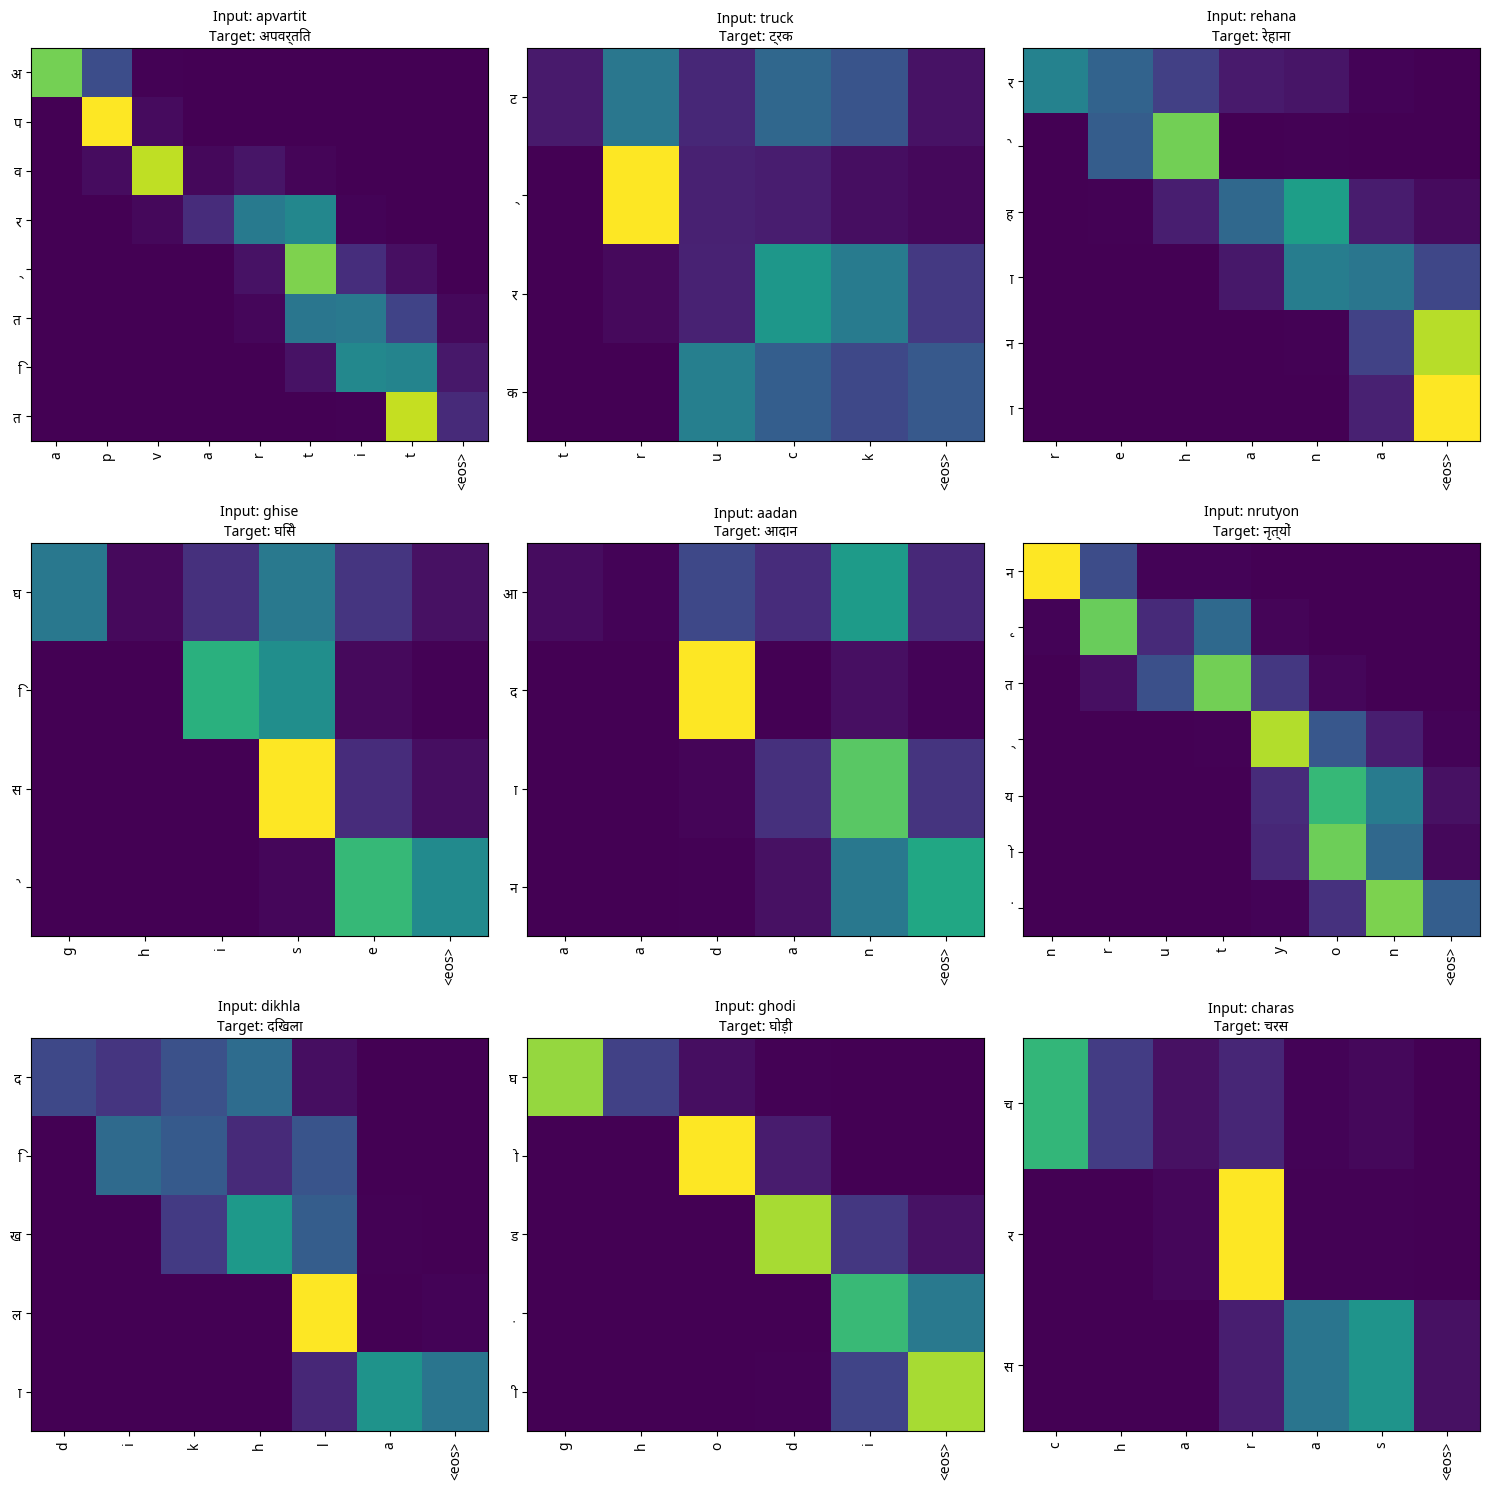

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Teacher Forcing Ratio,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test Accuracy,▁
Test Word Accuracy,▁
Train Accuracy,▁▃▄▅▅▆▆▆▇▇▇▇███
Train Loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁
Validation Accuracy,▁▄▅▆▇▇▇▇▇██████
Validation Loss,█▄▃▃▁▂▁▂▁▁▁▁▁▁▂
Epoch,15
Learning Rate,0.001


In [7]:
# ---------- Train Function ----------

def train_for_test():
    wandb.init(config={
        "embed_dim": 32,
        "hidden_dim": 128,
        "cell_type": "LSTM",
        "dropout": 0.2,
        "epochs": 15,
        "batch_size": 32,
        "learning_rate": 0.001,
        "optimizer": "adam",
        "teacher_forcing_ratio": 0.7,
    })

    
    config = wandb.config
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load data
    train_data = read_dataset("/kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv")
    dev_data = read_dataset("/kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv")

    # Build vocabs
    src_vocab, tgt_vocab = build_vocab([src for src, _ in train_data]), build_vocab([tgt for _, tgt in train_data])

    # Attention Seq2Seq model with 1 layer encoder-decoder (as per assignment requirement)
    model = Seq2Seq(len(src_vocab[0]), len(tgt_vocab[0]), config.embed_dim, config.hidden_dim,
                    config.cell_type, config.dropout).to(device)

    # Optimizer
    if config.optimizer == "adam":
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    elif config.optimizer == "nadam":
        optimizer = optim.NAdam(model.parameters(), lr=config.learning_rate)
    else:
        raise ValueError("Unsupported optimizer")

    criterion = nn.CrossEntropyLoss(ignore_index=0)

    for epoch in range(config.epochs):
        model.train()
        total_loss = 0
        total_acc = 0
        random.shuffle(train_data)
        
        for i in range(0, len(train_data), config.batch_size):
            batch = train_data[i:i + config.batch_size]
            src, trg = prepare_batch(batch, src_vocab[0], tgt_vocab[0], device)
            
            optimizer.zero_grad()
            output, _ = model(src, trg, teacher_forcing_ratio=config.teacher_forcing_ratio)
            loss = criterion(output[:, 1:].reshape(-1, output.shape[-1]), trg[:, 1:].reshape(-1))
            acc = calculate_word_accuracy(output[:, 1:], trg[:, 1:])
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_acc += acc

        avg_train_loss = total_loss / len(train_data)
        avg_train_acc = total_acc / (len(train_data) // config.batch_size)
        val_loss, val_acc = evaluate(model, dev_data, src_vocab[0], tgt_vocab[0], device, criterion, config.batch_size)

        wandb.log({
            "Train Loss": avg_train_loss,
            "Train Accuracy": avg_train_acc,
            "Validation Loss": val_loss,
            "Validation Accuracy": val_acc,
            "Epoch": epoch + 1,
            "Learning Rate": config.learning_rate,
            "Teacher Forcing Ratio": config.teacher_forcing_ratio,
        })

        print(f"Epoch {epoch + 1}/{config.epochs} | Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Log attention heatmaps at the end of training
    # Load your test data
    test_data = read_dataset("/kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv")
    
    # Call the function to predict and log test examples + word accuracy
    # predict_and_log_test_examples_with_attention(
    #     model=model,
    #     test_path="/kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv",
    #     src_vocab=src_vocab,
    #     tgt_vocab=tgt_vocab,
    #     device=device,
    #     num_examples=len(test_data),  # You can change to 9, 20 etc.
    #     output_csv_path="attention_predictions.csv"  # <-- desired CSV path
    # )


    test_acc = predict_and_log_test_examples_with_attention(
    model=model,
    test_path="/kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv",
    src_vocab=src_vocab,
    tgt_vocab=tgt_vocab,
    device=device,
    num_examples=len(test_data),  # You can change to 9, 20 etc.
    output_csv_path="/kaggle/working/attention_predictions_new.csv" )
    # <-- desired CSV path

    # Log test accuracy to wandb
    wandb.log({"Test Accuracy": test_acc})
    
    #print(f"Test Accuracy: {test_acc:.2f}%")

    

    log_attention_heatmaps_with_hindi(
            model=model,
            src_vocab=src_vocab,
            tgt_vocab=tgt_vocab,
            device=device,
            test_data=test_data,
            num_examples=9, # Exactly 9 for 3x3 grid
            font_path="/kaggle/input/nato-sans-devnagari/static/NotoSansDevanagari-Regular.ttf"
        )
    
    wandb.finish()


# ---------- Sweep Setup ----------
sweep_config = {
    'method': 'random',
    'metric': {'name': 'Validation Loss', 'goal': 'minimize'},
    'parameters': {
        'embed_dim': {'values': [32]},
        'hidden_dim': {'values': [128]},
        'enc_layers': {'values': [1]},
        'dec_layers': {'values': [3]},
        'cell_type': {'values': ['LSTM']},
        'dropout': {'values': [0.2]},
        'batch_size': {'value': 32},
        'epochs': {'value': 15},
        'bidirectional': {'values': [False]},
        'learning_rate': {'values': [0.001]},
        'optimizer': {'values': ['adam']},
        'teacher_forcing_ratio': {'values': [0.7]},
        'beam_width': {'values': [1]}
    }
}



# LSTM , GRU, RNN 1 3
sweep_id = wandb.sweep(sweep_config, project="with_attention_sweep_best_model_test_new123")
wandb.agent(sweep_id, function=train_for_test, count=1)

# Attention Visualisation

In [ ]:
## MOSTLY CODE TAKEN FROM BLOG GIVEN IN THE QUEUSTION ##
def get_clr(value):
    colors = ['#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8'
              '#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
              '#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
              '#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e']
    value = min(int((value * 100) / 5), len(colors)-1)
    return colors[value]

def cstr(s, color='black'):
    if s == ' ':
        return f"<text style=color:#000;padding-left:10px;background-color:{s}> </text>"
    return f"<text style=color:#000;background-color:{color}>{s} </text>"

# helps print colors in html document
def print_color(t):
    display(HTML(''.join([cstr(t_i, color=c_i) for (t_i, c_i) in t])))
 
# for each character being decoded, highlight the input sequence characters according to the attention weights
def visualize(input_word, output_word, attn_map, idx):
    print(f"Highlighting connectivity for: {output_word[idx]}")
    text_colours = [(c, get_clr(a)) for (c, a) in zip(input_word, attn_map[idx])]
    print_color(text_colours)
    print()
correct = 0
# sample and print the connectivity for 5 random samples
for _ in range(5):
    i = randint(0, len(df)-1)
    (x, y, z), mp = df[i], attention_weights[i]
    # to check how many of those sample are correct
    correct += int(y == z)
    # plot the visualization
    print(f"visualization for {x} --> {z}")
    for idx in range(len(z)):
        mp = mp[:len(z)][:, :len(x)]
        visualize(x, z, mp, idx)
    print("-"*50)
print(f"correct: {correct}/5")

In [ ]:
# connectivity_dakshina.py

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

#from your_model_file import Seq2Seq, build_vocab, read_dataset  # <-- update with actual module if needed

def visualize_attention(model, src_text, src_vocab, tgt_vocab, device):
    model.eval()
    src_ids = [src_vocab[0].get(c, src_vocab[0]['<unk>']) for c in src_text] + [src_vocab[0]['<eos>']]
    src_tensor = torch.tensor(src_ids, device=device).unsqueeze(0)

    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor)

    decoder_input = torch.tensor([tgt_vocab[0]['<sos>']], device=device)
    decoder_hidden = hidden
    decoder_states = []
    output_tokens = []

    for _ in range(30):
        output, decoder_hidden, attn_weights = model.decoder(decoder_input, decoder_hidden, encoder_outputs)
        top1 = output.argmax(1).item()
        if top1 == tgt_vocab[0]['<eos>']:
            break
        decoder_states.append(decoder_hidden[0][-1].squeeze(0).cpu().numpy() if isinstance(decoder_hidden, tuple) else decoder_hidden[-1].squeeze(0).cpu().numpy())
        output_tokens.append(top1)
        decoder_input = torch.tensor([top1], device=device)

    encoder_matrix = encoder_outputs.squeeze(0).cpu().numpy()
    similarities = [cosine_similarity([d], encoder_matrix)[0] for d in decoder_states]

    input_chars = [src_vocab[1][idx] for idx in src_ids]
    output_chars = [tgt_vocab[1][idx] for idx in output_tokens]

    plt.figure(figsize=(15, 8))
    sns.heatmap(np.array(similarities), xticklabels=input_chars, yticklabels=output_chars, cmap='coolwarm', cbar=True)
    plt.xlabel("Input Characters")
    plt.ylabel("Generated Output Characters")
    plt.title("Visualize attention")
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_path = "/kaggle/input/dakshina-dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv"
    model_path = "path/to/trained_model.pth"

    train_data = read_dataset(train_path)
    src_vocab = build_vocab([src for src, _ in train_data])
    tgt_vocab = build_vocab([tgt for _, tgt in train_data])

    model = Seq2Seq(
        input_dim=len(src_vocab[0]),
        output_dim=len(tgt_vocab[0]),
        embed_dim=128,
        hidden_dim=256,
        cell_type='LSTM',
        dropout=0.2
    ).to(device)

    model.load_state_dict(torch.load(model_path, map_location=device))
 
    visualize_attention(model, src_text=example_input, src_vocab=src_vocab, tgt_vocab=tgt_vocab, device=device)